In [1]:
# Retrieve the ratemap data saved from previous code.
# Spatial information and
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from tqdm import tqdm
import pdb
import sklearn.preprocessing
import math as mt
import copy as cp
import matplotlib.transforms as tsf
import seaborn as sns
import h5py

from maze_graph import *
from maze_utils2 import *

# read in a key .xlsx file which contains information of all sessions and all mice.
file = pd.read_excel("D:\YSY\mice_maze_metadata_time_correction.xls", sheet_name = "training_recording_new")  

# set the total path for figure saving
totalpath = "D:\YSY"

# Check whether the file path is existed or not
def FindPathOfPRPC(Rec):
    totalpath = "D:\YSY"
    path = os.path.join(totalpath,str(Rec[0]),str(Rec[1]),"rate_map_pcrc.pkl")
    if os.path.exists(path):
        return path
    return "F"

# Check whether the file path is existed or not
def FindPathOfRawRate(Rec):
    totalpath = "D:\YSY"
    path = os.path.join(totalpath,str(Rec[0]),str(Rec[1]),"rate_map_all.pkl")
    if os.path.exists(path):
        return path
    return "F"

# Check whether the file path is existed or not
def FindPathOfTime(Rec):
    totalpath = "D:\YSY"
    path = os.path.join(totalpath,str(Rec[0]),str(Rec[1]),"SI_cal.pkl")
    if os.path.exists(path):
        return path
    return "F"

# Return the array of pkl files in certain days. "days" provide the certain day.
def GetFilePathCollection(maze_type = 1, training_days = 1, file = file):
    days = training_days
    # index of collections
    Col_ind = np.where((file['training_day'] == days) & (file['maze_type'] == maze_type))[0]
    if len(Col_ind) == 0:
        return [],[],[]
    
    # Files that store the behav/ms information of cells. [spikes_all, spike_nodes_all, t_total_all, t_nodes_frac_all]
    ms_file = []     
    # Files that store the place cells(pc)' data. [rate_map_pc, rate_map_pc_norm, rate_map_ordered, rate_map_rc, rate_map_rc_norm, is_runcell_isi, rate_map_rc_ordered]
    pc_file = []
    # Files that store the all cells(ac)' data. [is_placecell_isi, SI_all, rate_map_all]
    ac_file = []
    
    for i in range(len(Col_ind)):
        NumDate = [0,0]
        NumDate[0] = file['number'][Col_ind[i]]
        NumDate[1] = file['date'][Col_ind[i]]
        if FindPathOfPRPC(NumDate) == "F" or FindPathOfRawRate(NumDate) == "F" or FindPathOfTime(NumDate) == "F":
            print(NumDate[0],NumDate[1]," Meet a FILE LOSS ERROR!")
            if FindPathOfPRPC(NumDate) == "F":
                print(os.path.join(totalpath,str(NumDate[0]),str(NumDate[1]),"rate_map_pcrc.pkl   LOSS"))
            if FindPathOfRawRate(NumDate) == "F":
                print(os.path.join(totalpath,str(NumDate[0]),str(NumDate[1]),"rate_map_all.pkl    LOSS"))
            if FindPathOfTime(NumDate) == "F":
                print(os.path.join(totalpath,str(NumDate[0]),str(NumDate[1]),"SI_cal.pkl          LOSS"))
            continue
        pc_file.append(FindPathOfPRPC(NumDate))
        ac_file.append(FindPathOfRawRate(NumDate))
        ms_file.append(FindPathOfTime(NumDate))
    if len(pc_file) != len(ac_file) or len(pc_file) != len(ms_file) or len(ac_file) != len(ms_file):
        print("Warning! The dimension of Col_file and SI_file is not the same! That may throw errors in later analysis!")
    return pc_file, ac_file, ms_file

In [83]:
# data_type = 'pc'  -- place cells, 
#             'ac'  -- all cells,
#             'npc' -- nonplace cells,
#             'pcn' -- place cell (normed),
#             'aSI'  -- Spatial information for all cells
#             'pSI'  -- Spatial information for place cells
#             'npSI' -- Spatial information for nonplace cells
#             'ispc_isi' -- is_placecll_isi
#             'spikes' -- Spatial information for nonplace cells
#             'spike_nodes' -- is_placecll_isi
#             't_total' -- Spatial information for nonplace cells
#             't_nodes_frac' -- is_placecll_isi
#             'aWPF'  -- WPFmap_allmice

def Combination(data_type = 'pc',training_days = 1, maze_type = 1):
    pc_file, ac_file, ms_file = GetFilePathCollection(file = file, training_days = training_days, maze_type = maze_type)
    
    # 'pc'  -- place cells firing rate, 'pcn' -- place cell firing rate (normed)。
    if data_type == 'pc' or data_type == 'pcn':
        data = []
        for i in range(len(pc_file)):
            if os.path.getsize(pc_file[i]) > 0:
                with open(pc_file[i],'rb') as handle:
                    pc_data = pickle.load(handle)
            else:
                print(pc_file[i],"is not existed!")
            if data_type == 'pc':
                for j in range(len(pc_data[0])):
                    data.append(pc_data[0][j])
            else:
                for j in range(len(pc_data[1])):
                    data.append(pc_data[1][j])
        return data
    
    # 'ac'  -- all cells,
    elif data_type == 'ac':
        data = []
        for i in range(len(ac_file)):
            if os.path.getsize(ac_file[i]) > 0:
                with open(ac_file[i],'rb') as handle:
                    ac_data = pickle.load(handle)
            else:
                print(ac_file[i],"is not existed!")
            for j in range(len(ac_data[2])):
                data.append(ac_data[2][j])
        return data
    
    # 'npc' -- nonplace cells,
    elif data_type == 'npc':
        data = []
        for i in range(len(ac_file)):
            if os.path.getsize(ac_file[i]) > 0:
                with open(ac_file[i],'rb') as handle:
                    ac_data = pickle.load(handle)
            else:
                print(ac_file[i],"is not existed!")
            for j in range(len(ac_data[2])):
                if ac_data[0][j] == 0: # is_placecell_isi[j] == 0 -> non place cell
                    data.append(ac_data[2][j])
        return data

    # 'aSI'  -- SI of all cells,
    elif data_type == 'aSI':
        data = []
        for i in range(len(ac_file)):
            if os.path.getsize(ac_file[i]) > 0:
                with open(ac_file[i],'rb') as handle:
                    ac_data = pickle.load(handle)
            else:
                print(ac_file[i],"is not existed!")
            for j in range(len(ac_data[1])):
                data.append(ac_data[1][j])
        return data
    
    # 'pSI'  --SI of place cells
    elif data_type == 'pSI':
        data = []
        for i in range(len(ac_file)):
            if os.path.getsize(ac_file[i]) > 0:
                with open(ac_file[i],'rb') as handle:
                    ac_data = pickle.load(handle)
            else:
                print(ac_file[i],"is not existed!")
            for j in range(len(ac_data[1])):
                if ac_data[0][j] == 1: # is_placecell_isi[j] == 0 -> non place cell
                    data.append(ac_data[1][j])
        return data
    
    # 'npSI'  --SI of nonplace cells
    elif data_type == 'npSI':
        data = []
        for i in range(len(ac_file)):
            if os.path.getsize(ac_file[i]) > 0:
                with open(ac_file[i],'rb') as handle:
                    ac_data = pickle.load(handle)
            else:
                print(ac_file[i],"is not existed!")
            for j in range(len(ac_data[1])):
                if ac_data[0][j] == 0: # is_placecell_isi[j] == 0 -> non place cell
                    data.append(ac_data[1][j])
        return data    
    
    # 'ispc_isi'  -- is_placecell_isi
    elif data_type == 'ispc_isi':
        data = []
        for i in range(len(ac_file)):
            if os.path.getsize(ac_file[i]) > 0:
                with open(ac_file[i],'rb') as handle:
                    ac_data = pickle.load(handle)
            else:
                print(ac_file[i],"is not existed!")
            for j in range(len(ac_data[0])):
                data.append(ac_data[0][j])
        return data
    
    # 'spikes'  -- spikes of all neurons, combined all neurons (in different mice)
    elif data_type == 'spikes':
        data = []
        for i in range(len(ms_file)):
            if os.path.getsize(ms_file[i]) > 0:
                with open(ms_file[i],'rb') as handle:
                    ms_data = pickle.load(handle)
            else:
                print(ms_file[i],"is not existed!")
            for j in range(len(ms_data[0])):
                data.append(ms_data[0][j])
        return data

    # 'spike_nodes'  -- spike_nodes of each spike, combined all neurons (in different mice)
    elif data_type == 'spike_nodes':
        data = []
        for i in range(len(ms_file)):
            if os.path.getsize(ms_file[i]) > 0:
                with open(ms_file[i],'rb') as handle:
                    ms_data = pickle.load(handle)
            else:
                print(ms_file[i],"is not existed!")
            for j in range(len(ms_data[1])):
                data.append(ms_data[1][j])
        return data
    
    # 't_total'  -- t_total of each session, combined all sessions
    elif data_type == 't_total':
        data = []
        for i in range(len(ms_file)):
            if os.path.getsize(ms_file[i]) > 0:
                with open(ms_file[i],'rb') as handle:
                    ms_data = pickle.load(handle)
            else:
                print(ms_file[i],"is not existed!")
            for j in range(len(ms_data[2])):
                data.append(ms_data[2][j])
        return data
    
    # 't_nodes_frac'  -- t_nodes_frac of each session, combined all sessions
    elif data_type == 't_nodes_frac':
        data = []
        for i in range(len(ms_file)):
            if os.path.getsize(ms_file[i]) > 0:
                with open(ms_file[i],'rb') as handle:
                    ms_data = pickle.load(handle)
            else:
                print(ms_file[i],"is not existed!")
            for j in range(len(ms_data[3])):
                data.append(ms_data[3][j])
        return data
    
    # WPFmap_allmice for place cells
    elif data_type[0:7] == 'aWPF_pc':
        rate_map_all = Get_split_FRdata(training_days = training_days,maze_type = maze_type, data_type = 'pc',path_type = 'ap')
        WPFmap_all = []
        for i in range(len(rate_map_all)):
            WPFmap = Generate_WholePlaceFieldMap(rate_map_all[i],maze_type)
            if data_type[8::] in ['','c','C','co','Co','cor','Cor','Core','core']:
                WPFmap = BubbleSortWithcore(WPFmap, rate_map_all[i])
            elif data_type[8::] in ['l','L','len','Len','le','Le','Length','length','lent','Lent','lenth','Lenth']:
                WPFmap = BubbleSortWithLength(WPFmap)
            elif data_type[8::] in ['d','D','Dist','dist','distance','Distance','di','Di','Dis','dis']:
                WPFmap = BubbleSortWithDistance(WPFmap, maze_type = maze_type)
            else:
                print("only 'c','C','co','Co','cor','Cor','Core','core','l','L','len','Len','le','Le','Length','length','lent','Lent','lenth','Lenth','d','D','Dist','dist','distance','Distance','di','Di','Dis','dis' are all legal.")
                print("Do you mean not sort the WPFmap?")
            WPFmap_all.append(WPFmap)
        return WPFmap_all
    
    # WPFmap_allmice for nonplace cells
    elif data_type[0:8] == 'aWPF_npc':
        rate_map_all = Get_split_FRdata(training_days = training_days,maze_type = maze_type, data_type = 'npc',path_type = 'ap')
        WPFmap_all = []
        for i in range(len(rate_map_all)):
            WPFmap = Generate_WholePlaceFieldMap(rate_map_all[i],maze_type)
            if data_type[9::] in ['','c','C','co','Co','cor','Cor','Core','core']:
                WPFmap = BubbleSortWithcore(WPFmap, rate_map_all[i])
            elif data_type[9::] in ['l','L','len','Len','le','Le','Length','length','lent','Lent','lenth','Lenth']:
                WPFmap = BubbleSortWithLength(WPFmap)
            elif data_type[9::] in ['d','D','Dist','dist','distance','Distance','di','Di','Dis','dis']:
                WPFmap = BubbleSortWithDistance(WPFmap, maze_type = maze_type)
            else:
                print("only 'c','C','co','Co','cor','Cor','Core','core','l','L','len','Len','le','Le','Length','length','lent','Lent','lenth','Lenth','d','D','Dist','dist','distance','Distance','di','Di','Dis','dis' are all legal.")
                print("Do you mean not sort the WPFmap?")
            WPFmap_all.append(WPFmap)
        return WPFmap_all
    
    # WPFmap_allmice for all cells
    elif data_type[0:7] == 'aWPF_ac':
        rate_map_all = Get_split_FRdata(training_days = training_days,maze_type = maze_type, data_type = 'adc',path_type = 'ap')
        WPFmap_all = []
        for i in range(len(rate_map_all)):
            WPFmap = Generate_WholePlaceFieldMap(rate_map_all[i],maze_type)
            if data_type[8::] in ['','c','C','co','Co','cor','Cor','Core','core']:
                WPFmap = BubbleSortWithcore(WPFmap, rate_map_all[i])
            elif data_type[8::] in ['l','L','len','Len','le','Le','Length','length','lent','Lent','lenth','Lenth']:
                WPFmap = BubbleSortWithLength(WPFmap)
            elif data_type[8::] in ['d','D','Dist','dist','distance','Distance','di','Di','Dis','dis']:
                WPFmap = BubbleSortWithDistance(WPFmap, maze_type = maze_type)
            else:
                print("only 'c','C','co','Co','cor','Cor','Core','core','l','L','len','Len','le','Le','Length','length','lent','Lent','lenth','Lenth','d','D','Dist','dist','distance','Distance','di','Di','Dis','dis' are all legal.")
                print("Do you mean not sort the WPFmap?")
            WPFmap_all.append(WPFmap)
        return WPFmap_all

    else:
        print("Invalid data_type! Please check your spelling! only value 'pc','ac','npc','pcn','si_all','spikes','spike_nodes','t_total','t_nodes_frac' are available!")
        return []
    
# Clean the NaN value
def Clear_Ratemap_NaN(rate_map_all):
    for j in range(len(rate_map_all)):
        for k in range(np.shape(rate_map_all)[1]):
            if mt.isnan(rate_map_all[j][k]):
                rate_map_all[j][k] = 0.0
    return rate_map_all

def calc_SI_path(training_days = 1, maze_type = 1, path_type = 'cp'):
    # SI in total path is no need to calculate but could be called in files directly
    if path_type == 'ap' or path_type == 'no':
        print("  Also you can get the answer, however we strongly recommend you to use function Combination() directly!")
        return Combination(training_days=training_days, maze_type=maze_type,data_type='aSI')
    
    spikes, spike_nodes, t_total, t_nodes_frac = Get_split_msdata(training_days = training_days, maze_type = maze_type, data_type = 'spikes',path_type=path_type)
    SI = np.zeros(len(spikes))
    for i in range(len(spikes)):
        SI[i] = calc_SI(spikes[i], spike_nodes[i], t_total[i], t_nodes_frac[i])
    return SI

# spatial information (for one neuron) 
# see DOI: 10.1126/science.aav9199
# mean_rate = sum(spikes)/t_total # mean firing rate
def calc_SI(spikes, rate_map, t_total, t_nodes_frac):
    mean_rate = sum(spikes)/t_total # mean firing rate
    logArg = rate_map / mean_rate;
    logArg[logArg == 0] = 1; # keep argument in log non-zero

    IC = np.nansum(t_nodes_frac * rate_map * np.log2(logArg)) # information content
    SI = IC / mean_rate; # spatial information (bits/spike)
    return(SI)

In [77]:
a = 'cbwqe sae'
print(a[4])

e


In [3]:
# split data in correct path, incorrect path or reorder them in a ranked order.
# path_type : 'ap' (all path in certain order), 'cp' (correct path), 'icp'(incorrect path), 'no' (not orderred all path)

# data_type = 'pc'  -- place cells, 
#             'ac'  -- all cells,
#             'npc' -- nonplace cells,
#             'pcn' -- place cell (normed),
#             'aSI'  -- Spatial information for all cells
#             'pSI'  -- Spatial information for place cells
#             'npSI' -- Spatial information for nonplace cells
#             'ispc_isi' -- is_placecll_isi
#             'spikes' -- Spatial information for nonplace cells
#             'spike_nodes' -- is_placecll_isi
#             't_total' -- Spatial information for nonplace cells
#             't_nodes_frac' -- is_placecll_isi

# split ms/behav data with different path
def Get_split_msdata(data_type = 'spikes',training_days = 1, maze_type = 1, path_type = 'ap', GetFourResults = 1):
    # Get four necessary variable matrices.
    bef_spikes = Combination(data_type = 'spikes', training_days = training_days, maze_type = maze_type)
    bef_spike_nodes = Combination(data_type = 'spike_nodes', training_days = training_days, maze_type = maze_type)
    bef_t_total = Combination(data_type = 't_total', training_days = training_days, maze_type = maze_type)
    bef_t_nodes_frac = Combination(data_type = 't_nodes_frac', training_days = training_days, maze_type = maze_type)
    
    correct_path = CorrectPath_maze_1 if maze_type == 1 else CorrectPath_maze_2
    incorrect_path = IncorrectPath_maze_1 if maze_type == 1 else IncorrectPath_maze_2
    reorderred_path = correct_path + incorrect_path
    
    if path_type in ['no','ap']:
        if GetFourResults == 1:
            if data_type in ['spikes','spike_nodes','t_total','t_nodes_frac']:
                return [bef_spikes,bef_spike_nodes,bef_t_total,bef_t_nodes_frac]
            elif data_type in ['pc','ac','npc']:
                print("WARNING!!! You should use another funciton Get_split_FRdata() to deel with data_type '"+str(data_type)+"'")
                print("Here we help you to call this funciton. However we strongly recommend you to correct it.")
                return Get_split_FRdata(data_type = data_type,training_days = training_days, maze_type = maze_type, path_type = path_type)
            else:
                print("WARNING!!! Type Error !!! data_type '",data_type,"' cannot be split into correct path!")
                return []
            
        else:
            if data_type == 'spikes':
                return bef_spikes
            elif data_type == 'spike_nodes':
                return bef_spike_nodes
            elif data_type == 't_total':
                return bef_t_total
            elif data_type == 't_nodes_frac':
                return bef_t_nodes_frac
            elif data_type in ['pc','ac','npc']:
                print("WARNING!!! You should use another funciton Get_split_FRdata() to deel with data_type '"+str(data_type)+"'")
                print("Here we help you to call this funciton. However we strongly recommend you to correct it.")
                return Get_split_FRdata(data_type = data_type,training_days = training_days, maze_type = maze_type, path_type = path_type)
            else:
                print("WARNING!!! Type Error !!! data_type '",data_type,"' cannot be split into correct path!")
                return []    
    
    elif path_type == 'cp':
        print('path_type = '+path_type)
        if data_type in ['pc','ac','npc']:
            print("WARNING!!! You should use another funciton Get_split_FRdata() to deel with data_type '"+str(data_type)+"'")
            print("Here we help you to call this funciton. However we strongly recommend you to correct it.")
            return Get_split_FRdata(data_type = data_type,training_days = training_days, maze_type = maze_type, path_type = path_type)
        
        elif data_type in ['spikes','spike_nodes','t_total','t_nodes_frac']:
            print("data_type: "+data_type)
            aft_spikes = []
            aft_spike_nodes = []
            aft_t_total = np.zeros_like(bef_t_total)    # n_neuron_all * 1
            aft_t_nodes_frac = np.zeros((len(bef_t_total),len(correct_path)))  # n_neuron_all * 144(111/xxx)
            if len(bef_t_total) != len(bef_t_nodes_frac):
                print("WARNING!!! the dimension of t_total is not equal to the dimension of t_nodes_frac_all, that may cause ERROR in later analysis!")
            
            print("began to calculate time")
            for i in range(len(bef_t_total)):
                for k in range(len(correct_path)):
                    aft_t_nodes_frac[i][k] = bef_t_nodes_frac[i][correct_path[k]-1]
                    if np.isnan(bef_t_nodes_frac[i][correct_path[k]-1] * bef_t_total[i]):
                        continue
                    aft_t_total[i] += bef_t_nodes_frac[i][correct_path[k]-1] * bef_t_total[i]   
            aft_t_nodes_frac = Norm_t_nodes_frac_part(aft_t_nodes_frac)
            
            print("began to calculate spikes")
            for i in range(len(bef_spikes)):
                ind = [list(np.where(np.array(bef_spike_nodes[i]) == correct_path[j])[0]) for j in range(len(correct_path))]
                merge_ind = sum(ind,[])
                co_spikes = [bef_spikes[i][k] for k in merge_ind]
                co_spike_nodes = [bef_spike_nodes[i][k] for k in merge_ind]

                aft_spike_nodes.append(co_spike_nodes)
                aft_spikes.append(co_spikes)
        
            print("Finish calculating!")
            
            if GetFourResults == 1:
                return [aft_spikes,aft_spike_nodes,aft_t_total,aft_t_nodes_frac]
            else:
                if data_type == 'spikes':
                    return aft_spikes
                elif data_type == 'spike_nodes':
                    return aft_spike_nodes
                elif data_type == 't_total':
                    return aft_t_total
                elif data_type == 't_nodes_frac':
                    return aft_t_nodes_frac
                else:
                    print("ERROR!")
                    return []
        
        else:
            print("WARNING!!! Type Error !!! data_type '",data_type,"' cannot be split into correct path!")
            return []
        
    elif path_type == 'icp':
        if data_type in ['pc','ac','npc']:
            print("WARNING!!! You should use another funciton Get_split_FRdata() to deel with data_type '"+str(data_type)+"'")
            print("Here we help you to call this funciton. However we strongly recommend you to correct it.")
            return Get_split_FRdata(data_type = data_type,training_days = training_days, maze_type = maze_type, path_type = path_type)
        
        elif data_type in ['spikes','spike_nodes','t_total','t_nodes_frac']:
            aft_spikes = []
            aft_spike_nodes = []
            aft_t_total = np.zeros_like(bef_t_total)    # n_neuron_all * 1
            aft_t_nodes_frac = np.zeros((len(bef_t_total),len(incorrect_path)))  # n_neuron_all * 144(111/xxx)
            if len(bef_t_total) != len(bef_t_nodes_frac):
                print("WARNING!!! the dimension of t_total is not equal to the dimension of t_nodes_frac_all, that may cause ERROR in later analysis!")
            
            for i in range(len(bef_t_total)):
                for k in range(len(incorrect_path)):
                    aft_t_nodes_frac[i][k] = bef_t_nodes_frac[i][incorrect_path[k]-1]
                    if np.isnan(bef_t_nodes_frac[i][incorrect_path[k]-1] * bef_t_total[i]):
                        continue
                    aft_t_total[i] += bef_t_nodes_frac[i][incorrect_path[k]-1] * bef_t_total[i]   
            aft_t_nodes_frac = Norm_t_nodes_frac_part(aft_t_nodes_frac)
            
            for i in range(len(bef_spikes)):
                ind = [list(np.where(np.array(bef_spike_nodes[i]) == incorrect_path[j])[0]) for j in range(len(incorrect_path))]
                merge_ind = sum(ind,[])
                inco_spikes = [bef_spikes[i][k] for k in merge_ind]
                inco_spike_nodes = [bef_spike_nodes[i][k] for k in merge_ind]

                aft_spike_nodes.append(inco_spike_nodes)
                aft_spikes.append(inco_spikes)
            
            if GetFourResults == 1:
                return [aft_spikes,aft_spike_nodes,aft_t_total,aft_t_nodes_frac]
            else:
                if data_type == 'spikes':
                    return aft_spikes
                elif data_type == 'spike_nodes':
                    return aft_spike_nodes
                elif data_type == 't_total':
                    return aft_t_total
                elif data_type == 't_nodes_frac':
                    return aft_t_nodes_frac
                else:
                    print("ERROR!")
                    return []
        
        else:
            print("WARNING!!! Type Error !!! data_type '",data_type,"' cannot be split into correct path!")
            return []
    
    else:
        print("Invalid path_type! Please check your spelling! only value 'spikes','in','ap','no' are acceptable!")
        return []        
              
              
#---------------------------------------------------------------------------------------------------------------------------------------
# split firing rate data with different path
def Get_split_FRdata(data_type = 'pc',training_days = 1, maze_type = 1, path_type = 'ap'):
    bef_data = Combination(data_type = data_type, training_days = training_days, maze_type = maze_type)
    
    correct_path = CorrectPath_maze_1 if maze_type == 1 else CorrectPath_maze_2
    incorrect_path = IncorrectPath_maze_1 if maze_type == 1 else IncorrectPath_maze_2
    reorderred_path = correct_path + incorrect_path
    
    if path_type == 'no':
        bef_data = Clear_Ratemap_NaN(bef_data)
        return bef_data
    
    elif path_type == 'cp':
        if data_type in ['spikes','spike_nodes','t_total','t_nodes_frac']:
            print("WARNING!!! You should use another funciton Get_split_msdata() to deel with data_type '"+str(data_type)+"'")
            print("Here we help you to call this funciton. However we strongly recommend you to correct it.")
            return Get_split_msdata(data_type = data_type,training_days = training_days, maze_type = maze_type, path_type = path_type)
        
        elif data_type in ['pc','ac','npc']:
            bef_data = Clear_Ratemap_NaN(bef_data)
            aft_data = np.zeros((len(bef_data),len(correct_path)))
            for i in range(len(bef_data)):
                for j in range(len(aft_data[0])):
                    aft_data[i][j] = bef_data[i][correct_path[j]-1]
            print("Get_split_FRdata: ",np.shape(aft_data))
            return aft_data
        
        else:
            print("WARNING!!! Type Error !!! data_type '",data_type,"' cannot be split into correct path!")
            return []
        
    elif path_type == 'icp':
        if data_type in ['spikes','spike_nodes','t_total','t_nodes_frac']:
            print("WARNING!!! You should use another funciton Get_split_msdata() to deel with data_type '"+str(data_type)+"'")
            print("Here we help you to call this funciton. However we strongly recommend you to correct it.")
            return Get_split_msdata(data_type = data_type,training_days = training_days, maze_type = maze_type, path_type = path_type)
        
        elif data_type in ['pc','ac','npc']:
            bef_data = Clear_Ratemap_NaN(bef_data)
            aft_data = np.zeros((len(bef_data),len(incorrect_path)))
            for i in range(len(bef_data)):
                for j in range(len(aft_data[0])):
                    aft_data[i][j] = bef_data[i][incorrect_path[j]-1]
            print("Get_split_FRdata: ",np.shape(aft_data))
            return aft_data
        
        else:
            print("WARNING!!! Type Error !!! data_type '",data_type,"' cannot be split into correct path!")
            return []
        
    elif path_type == 'ap':
        if data_type in ['spikes','spike_nodes','t_total','t_nodes_frac']:
            print("WARNING!!! You should use another funciton Get_split_msdata() to deel with data_type '"+str(data_type)+"'")
            print("Here we help you to call this funciton. However we strongly recommend you to correct it.")
            return Get_split_msdata(data_type = data_type,training_days = training_days, maze_type = maze_type, path_type = path_type)
        
        elif data_type in ['pc','ac','npc']:
            bef_data = Clear_Ratemap_NaN(bef_data)
            aft_data = np.zeros((len(bef_data),len(reorderred_path)))
            for i in range(len(bef_data)):
                for j in range(len(aft_data[0])):
                    aft_data[i][j] = bef_data[i][reorderred_path[j]-1]
            print("Get_split_FRdata: ",np.shape(aft_data))
            return aft_data
        
        else:
            print("WARNING!!! Type Error !!! data_type '",data_type,"' cannot be split into correct path!")
            return []
    
    else:
        print("Invalid path_type! Please check your spelling! only value 'cp','icp','ap','no' are acceptable!")
        return []        

#---------------------------------------------------------------------------------------------------------------------------------------
# split spatial information with different path   
def Get_Split_SIdata(training_days = 1, maze_type = 1, data_type = 'pc'):
    # Devide the data into two groups: the correct path group and the incorrect path group
    msdata_co = Get_split_msdata(training_days = training_days, maze_type = maze_type, data_type = 'spikes', path_type = 'cp')
    ratemap_co = Get_split_FRdata(training_days = training_days, maze_type = maze_type, data_type = 'ac', path_type = 'cp')
    msdata_inc = Get_split_msdata(training_days = training_days, maze_type = maze_type, data_type = 'spikes', path_type = 'icp')
    ratemap_inc = Get_split_FRdata(training_days = training_days, maze_type = maze_type, data_type = 'ac', path_type = 'icp')
    
    aSI = Combination(training_days = training_days, maze_type = maze_type, data_type = 'aSI')
    pSI = Combination(training_days = training_days, maze_type = maze_type, data_type = 'pSI')
    npSI = Combination(training_days = training_days, maze_type = maze_type, data_type = 'npSI')
    is_placecell_isi_all = Combination(training_days = training_days, maze_type = maze_type, data_type = 'ispc_isi')
    
    SI_co_all = np.zeros(len(is_placecell_isi_all))
    SI_inc_all = np.zeros(len(is_placecell_isi_all))
    for i in range(len(is_placecell_isi_all)):
        SI_co_all[i] = calc_SI(msdata_co[0][i],ratemap_co[i],msdata_co[2][i],msdata_co[3][i])
        SI_inc_all[i] = calc_SI(msdata_inc[0][i],ratemap_inc[i],msdata_inc[2][i],msdata_inc[3][i])
    
    if data_type == 'pc':
        pc_SI_co = []
        pc_SI_inc = []
        for i in range(len(is_placecell_isi_all)):
            if is_placecell_isi_all[i] == 1:
                pc_SI_co.append(SI_co_all[i])
                pc_SI_inc.append(SI_inc_all[i])
        return pSI, pc_SI_co, pc_SI_inc
    
    elif data_type == 'npc':
        npc_SI_co = []
        npc_SI_inc = []
        for i in range(len(is_placecell_isi_all)):
            if is_placecell_isi_all[i] == 0:
                npc_SI_co.append(SI_co_all[i])
                npc_SI_inc.append(SI_inc_all[i])
        return npSI, npc_SI_co, npc_SI_inc        
    
    elif data_type == 'ac':
        return aSI, SI_co_all, SI_inc_all
    
    else:
        print("Invalid path_type! Please check your spelling! only value 'pc','npc','ac' are acceptable!")
        return aSI, SI_co_all, SI_inc_all

    
def Norm_t_nodes_frac_part(t_nodes_frac):
    t_nodes_frac_norm = np.zeros_like(t_nodes_frac)
    for i in range(len(t_nodes_frac_norm)):
        sum_all = np.nansum(t_nodes_frac[i])
        for j in range(len(t_nodes_frac_norm[i])):
            if np.isnan(t_nodes_frac[i][j]):
                t_nodes_frac_norm[i][j] = np.nan
            else:
                t_nodes_frac_norm[i][j] = t_nodes_frac[i][j]/sum_all
    return t_nodes_frac_norm

def Norm_ratemap(rate_map_all):
    rate_map_all_norm = sklearn.preprocessing.minmax_scale(rate_map_all, feature_range=(0, 1), axis=1, copy=True)
    return rate_map_all_norm

In [4]:
msdata = Get_split_msdata(maze_type=1,data_type ='spikes',training_days = 1, path_type='cp')
is_place_cell_isi = Combination(maze_type=1,data_type = 'ispc_isi', training_days = 1)
aSI = Combination(maze_type=1,data_type='aSI',training_days = 1)
pSI = Combination(maze_type=1,data_type='pSI',training_days = 1)
npSI = Combination(maze_type=1,data_type='npSI',training_days = 1)
pc_ratemap = Combination(maze_type=1,data_type='pc',training_days = 1)
ac_ratemap = Combination(maze_type=1,data_type='ac',training_days = 1)
npc_ratemap = Combination(maze_type=1,data_type='npc',training_days = 1)

print(len(msdata[0]))
print(len(is_place_cell_isi))
print(len(aSI))
print(len(pSI))
print(len(npSI))
print(len(ac_ratemap))
print(len(pc_ratemap))
print(len(npc_ratemap))

10027 20200417  Meet a FILE LOSS ERROR!
D:\YSY\10027\20200417\rate_map_pcrc.pkl   LOSS
D:\YSY\10027\20200417\rate_map_all.pkl    LOSS
D:\YSY\10027\20200417\SI_cal.pkl          LOSS
10027 20200417  Meet a FILE LOSS ERROR!
D:\YSY\10027\20200417\rate_map_pcrc.pkl   LOSS
D:\YSY\10027\20200417\rate_map_all.pkl    LOSS
D:\YSY\10027\20200417\SI_cal.pkl          LOSS
10027 20200417  Meet a FILE LOSS ERROR!
D:\YSY\10027\20200417\rate_map_pcrc.pkl   LOSS
D:\YSY\10027\20200417\rate_map_all.pkl    LOSS
D:\YSY\10027\20200417\SI_cal.pkl          LOSS
10027 20200417  Meet a FILE LOSS ERROR!
D:\YSY\10027\20200417\rate_map_pcrc.pkl   LOSS
D:\YSY\10027\20200417\rate_map_all.pkl    LOSS
D:\YSY\10027\20200417\SI_cal.pkl          LOSS
path_type = cp
data_type: spikes
began to calculate time
began to calculate spikes
Finish calculating!
10027 20200417  Meet a FILE LOSS ERROR!
D:\YSY\10027\20200417\rate_map_pcrc.pkl   LOSS
D:\YSY\10027\20200417\rate_map_all.pkl    LOSS
D:\YSY\10027\20200417\SI_cal.pkl       

In [5]:
# sort the rate_map
def isAllZero(rate_map):
    for i in range(len(rate_map)):
        if rate_map[i] != 0:
            return 0
    return 1

def find_the_summit(rate_map):
    return np.argmax(rate_map)

# Generate the array that contains the summit firing rate of each neuron.
def Generate_Summit_Arr(rate_map_all):
    arr = np.zeros(len(rate_map_all))
    for i in range(len(rate_map_all)):
        if isAllZero(rate_map_all[i]):
            arr[i]=145
        else:
            arr[i] = find_the_summit(rate_map_all[i])
    return arr

# sort the rate_map
def partition(index_map, RecordVec, low, high): 
    i = low - 1         
    pivot = RecordVec[high]       
    for j in range(low, high): 
        if   RecordVec[j] > pivot:           
            i = i+1
            RecordVec[i], RecordVec[j] = RecordVec[j], RecordVec[i]
            c = cp.deepcopy(index_map[i,:])
            index_map[i, :] = cp.deepcopy(index_map[j, :])
            index_map[j, :] = cp.deepcopy(c)      
            
    RecordVec[i+1], RecordVec[high] = RecordVec[high], RecordVec[i+1]
    c = cp.deepcopy(index_map[i+1,:])
    index_map[i+1, :] = cp.deepcopy(index_map[high, :])
    index_map[high, :] = cp.deepcopy(c)
    return i+1 
    
def quickSort(index_map, RecordVec, low, high): 
    if low < high:   
        pi = partition(index_map, RecordVec, low, high)
        quickSort(index_map, RecordVec, low, pi-1)
        quickSort(index_map, RecordVec, pi+1, high)

def sort_rate_map(rate_map_all):
    index_arr = Generate_Summit_Arr(rate_map_all)
    quickSort(rate_map_all, index_arr,0,len(rate_map_all)-1)

In [60]:
# Figuring the all mice ratemap
# More details about settings of colorbar: https://wap.sciencenet.cn/blog-587102-1322640.html

def add_right_cax(ax, pad, width):
    # creat a new position on the right of ax, with the same height
    # pad is the interval between cax and ax, width is the width of cax
    axpos = ax.get_position()
    caxpos = tsf.Bbox.from_extents(
        axpos.x1 + pad,
        axpos.y0,
        axpos.x1 + pad + width,
        axpos.y1)
    cax = ax.figure.add_axes(caxpos)
    return cax

def plot_rate_map(rate_map = None,ax = None,title = " No title ",path_type = 'cp',maze_type = 1, xlabel = "MazeID",ylabel = "NeuronID",colorbarName = "Normalized Firing Rate"):
    # plot the rate map in one day
    tag_site = separate_point1 if maze_type == 1 else separate_point2
    co_path = CorrectPath_maze_1 if maze_type == 1 else CorrectPath_maze_2
    ma = ax.imshow(rate_map,interpolation='none',origin = "lower",alpha = 1,aspect = 'auto')
    if path_type == 'icp':
        for k in range(len(tag_site)):
            ax.axvline(x=tag_site[k], color = 'white',linewidth = 1, ls = '--')
        ax.set_xlabel("Incorrect Path", fontsize = 16)
    elif path_type == 'cp':
        ax.set_xlabel("Correct Path", fontsize = 16)
    elif path_type == 'ap':
        for k in range(len(tag_site)):
            ax.axvline(x=tag_site[k]+len(co_path), color = 'white',linewidth = 1, ls = '--')
        ax.set_xlabel(xlabel,fontsize = 16)
    else:
        print("Invalid path type '"+path_type+"'. Check your spelling! only value 'cp','ap','icp' are acceptable!")
        ax.set_xlabel(xlabel,fontsize = 16)
    ax.set_title(title, fontsize = 16)
    ax.set_ylabel(ylabel, fontsize = 16)
    am = fig.colorbar(ma,ax = ax, fraction = 0.08)
    am.set_label(colorbarName)

10027 20200417  Meet a FILE LOSS ERROR!
D:\YSY\10027\20200417\rate_map_pcrc.pkl   LOSS
D:\YSY\10027\20200417\rate_map_all.pkl    LOSS
D:\YSY\10027\20200417\SI_cal.pkl          LOSS


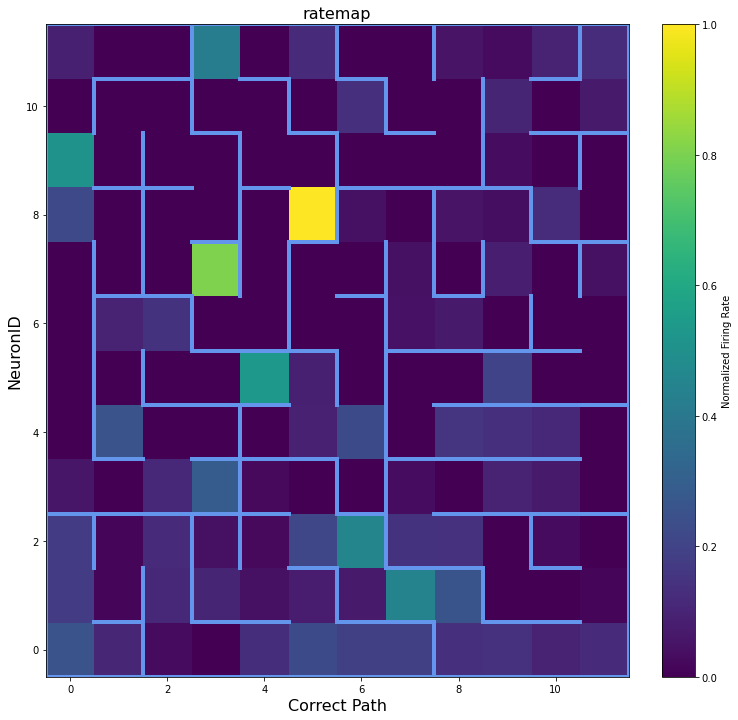

In [64]:
# draw maze outline
def isNorthBorder(mazeID):
    if mazeID/12 > 11:
        return 1
    else:
        return 0

def isEastBorder(mazeID):
    if mazeID % 12 == 0:
        return 1
    else:
        return 0

def isWestBorder(mazeID):
    if mazeID % 12 == 1:
        return 1
    else:
        return 0

def isSouthBorder(mazeID):
    if mazeID <= 12:
        return 1
    else:
        return 0

def OrdiToID(x,y):
    return y*12 + x + 1
    
def drawMazeOnRatemap(maze_type = 1,axes = None, color = 'white'):
    graph = maze1_graph if maze_type == 1 else maze2_graph
    for i in range(1,145):
        x = (i-1) % 12
        y = int((i-1) / 12)
        surr = graph[i]
        border = [0,0,0,0] # E,S,W,N
        if isEastBorder(i):
            axes.plot([x+0.5, x+0.5],[y+0.5, y-0.5],'-',color = color,linewidth = 4)
            border[0] = 1
        if isSouthBorder(i):
            axes.plot([x-0.5, x+0.5],[y-0.5, y-0.5],'-',color = color,linewidth = 4)
            border[1] = 1
        if isWestBorder(i):
            axes.plot([x-0.5, x-0.5],[y-0.5, y+0.5],'-',color = color,linewidth = 4)
            border[2] = 1
        if isNorthBorder(i):
            axes.plot([x-0.5, x+0.5],[y+0.5, y+0.5],'-',color = color,linewidth = 4)
            border[3] = 1
        # axes.text(x-0.08,y-0.08,i,color = 'white')
        for k in range(4):
            if border[0] != 1 and OrdiToID(x+1,y) not in surr:
                axes.plot([x+0.5, x+0.5],[y-0.5, y+0.5],'-',color = color,linewidth = 4)
            if border[1] != 1 and OrdiToID(x,y-1) not in surr:
                axes.plot([x-0.5, x+0.5],[y-0.5, y-0.5],'-',color = color,linewidth = 4)
            if border[2] != 1 and OrdiToID(x-1,y) not in surr:
                axes.plot([x-0.5, x-0.5],[y-0.5, y+0.5],'-',color = color,linewidth = 4)
            if border[3] != 1 and OrdiToID(x,y+1) not in surr:
                axes.plot([x-0.5, x+0.5],[y+0.5, y+0.5],'-',color = color,linewidth = 4)
    
fig = plt.figure(figsize=[(12), (12)])
axes = fig.add_subplot(1, 1, 1)
rate_map_all = Get_split_FRdata(maze_type=1,training_days=1,data_type = 'npc', path_type='no')
rate_map_all_norm = Norm_ratemap(rate_map_all)
ratemap = rate_map_all_norm[2]
rate_map_2d = np.reshape(ratemap, [12,12])
plot_rate_map(rate_map_2d, axes, title = "ratemap", path_type = 'cp', maze_type = 1)
drawMazeOnRatemap(maze_type = 1,axes = axes, color = 'cornflowerblue')

10027 20200417  Meet a FILE LOSS ERROR!
D:\YSY\10027\20200417\rate_map_pcrc.pkl   LOSS
D:\YSY\10027\20200417\rate_map_all.pkl    LOSS
D:\YSY\10027\20200417\SI_cal.pkl          LOSS
Get_split_FRdata:  (580, 111)
10027 20200417  Meet a FILE LOSS ERROR!
D:\YSY\10027\20200417\rate_map_pcrc.pkl   LOSS
D:\YSY\10027\20200417\rate_map_all.pkl    LOSS
D:\YSY\10027\20200417\SI_cal.pkl          LOSS
Get_split_FRdata:  (580, 33)


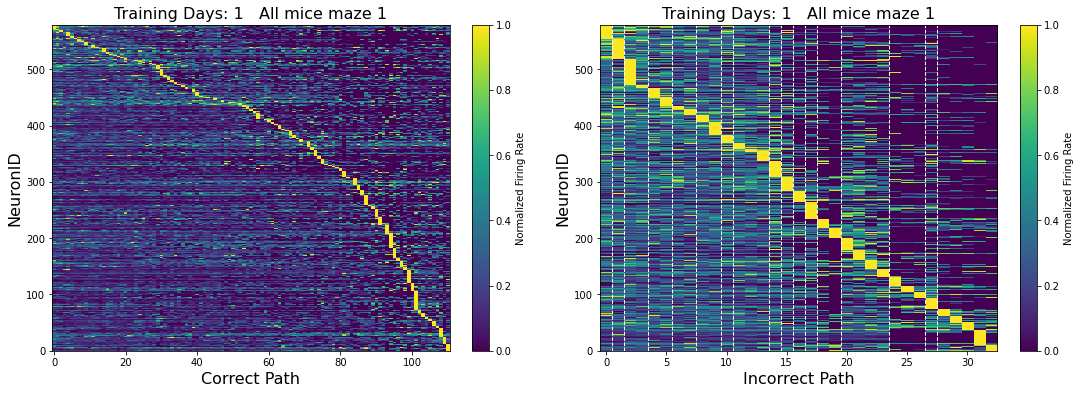

In [8]:
# Example
fig, axs = plt.subplots(1,2,figsize=(18,6))
ax_co = axs[0]
ax_inc = axs[1]

pc_ratemap_co = Get_split_FRdata(data_type = 'pc',path_type='cp',maze_type=1,training_days = 1)
pc_ratemap_inc = Get_split_FRdata(data_type = 'pc',path_type='icp',maze_type=1,training_days = 1)
pc_ratemap_co_norm = Norm_ratemap(pc_ratemap_co)
pc_ratemap_inc_norm = Norm_ratemap(pc_ratemap_inc)
sort_rate_map(pc_ratemap_co_norm)
sort_rate_map(pc_ratemap_inc_norm)
plot_rate_map(pc_ratemap_co_norm,ax_co,"Training Days: "+str(1)+"   All mice maze 1",path_type = 'cp',maze_type = 1)
plot_rate_map(pc_ratemap_inc_norm,ax_inc,"Training Days: "+str(1)+"   All mice maze 1",path_type = 'icp',maze_type = 1)
plt.subplots_adjust(wspace=0.2, hspace=0)

In [9]:
# This figure consists of 4 rows with 9 columns.
# line 1,2 plots the 15 subfigures of correct path, divided by different maze type.
# line 3,4 plots the 15 subfigures of incorrect path, divided by different maze type.

def plot_all_ratemap(data_type = 'pc'):
    fig, axs = plt.subplots(2,9,figsize=(54,12))
    for k in [0,1,2,3,4,5,6,7,8]:
        # Devide the data into two groups: the correct path group and the incorrect path group
        rate_map_all_co = Get_split_FRdata(training_days=k+1,maze_type=1,data_type = data_type,path_type='cp')
        rate_map_all_inc = Get_split_FRdata(training_days=k+1,maze_type=1,data_type = data_type,path_type='icp')
        rate_map_all_co = Norm_ratemap(rate_map_all_co)
        rate_map_all_inc = Norm_ratemap(rate_map_all_inc)
        
        ax_co = axs[0][k]
        ax_inc = axs[1][k]
        
        rate_map_all_co = np.array(rate_map_all_co)
        rate_map_all_inc = np.array(rate_map_all_inc)
        sort_rate_map(rate_map_all_co)
        sort_rate_map(rate_map_all_inc)
        plot_rate_map(rate_map_all_co,ax_co,"Training Day:"+str(k+1)+" | All mice maze 1 "+data_type,True,1)
        plot_rate_map(rate_map_all_inc,ax_inc,"Training Day:"+str(k+1)+" | All mice maze 1 "+data_type,False,1)
    plt.subplots_adjust(wspace=0.5, hspace=0.3)
    plt.savefig(os.path.join(totalpath,"all_mice_data_maze","All_mice_ratemap_maze1_"+data_type+".pdf"),dpi=600)
    plt.savefig(os.path.join(totalpath,"all_mice_data_maze","All_mice_ratemap_maze1_"+data_type+".png"),dpi=600)
    print("Figure maze1 has done...")
    
    fig, axs = plt.subplots(2,8,figsize=(48,12))
    for k in [9,10,11,12,13,14,15,16]:
        # Devide the data into two groups: the correct path group and the incorrect path group        
        rate_map_all_co = Get_split_FRdata(training_days=k-8,maze_type=2,data_type = data_type,path_type='cp')
        rate_map_all_inc = Get_split_FRdata(training_days=k-8,maze_type=2,data_type = data_type,path_type='icp')
        rate_map_all_co = Norm_ratemap(rate_map_all_co)
        rate_map_all_inc = Norm_ratemap(rate_map_all_inc)
        
        
        ax_co = axs[0][k-9]
        ax_inc = axs[1][k-9]
        rate_map_all_co = np.array(rate_map_all_co)
        rate_map_all_inc = np.array(rate_map_all_inc)
        sort_rate_map(rate_map_all_co)
        sort_rate_map(rate_map_all_inc)
        plot_rate_map(rate_map_all_co,ax_co,"Training Day:"+str(k-8)+" | All mice maze 2 "+data_type,True,2)
        plot_rate_map(rate_map_all_inc,ax_inc,"Training Day:"+str(k-8)+" | All mice maze 2"+data_type,False,2)
    plt.subplots_adjust(wspace=0.5, hspace=0.3)
    plt.savefig(os.path.join(totalpath,"all_mice_data_maze","All_mice_ratemap_maze2_"+data_type+".pdf"),dpi=600)
    plt.savefig(os.path.join(totalpath,"all_mice_data_maze","All_mice_ratemap_maze2_"+data_type+".png"),dpi=600)
    print("Figure maze2 has done...")

# plot_all_ratemap(data_type='pc')
# plot_all_ratemap(data_type='npc')
# plot_all_ratemap(data_type='ac')

10027 20200417  Meet a FILE LOSS ERROR!
D:\YSY\10027\20200417\rate_map_pcrc.pkl   LOSS
D:\YSY\10027\20200417\rate_map_all.pkl    LOSS
D:\YSY\10027\20200417\SI_cal.pkl          LOSS
[0.77913856 0.91340884 0.22665458 1.83211193 1.36088086 0.1067122
 0.18108288 0.56878508 0.08926977 0.54854635 0.12341108 0.65414447
 0.87293153 0.48376368 0.14712373 0.         0.4063153  0.23122278
 0.         0.         0.19849146 0.         0.         0.07190623
 0.94476286 0.         0.06587615 0.         0.         0.
 0.         0.         0.         0.         0.         0.10527424
 0.23364486 0.79051383 0.         0.         0.10117361 0.
 0.56561086 0.         0.24050024 0.38233607 0.2787068  0.22446689
 0.         0.         0.         0.         0.         0.34977265
 0.         0.56593096 0.         0.         0.4222973  0.5214444
 0.         0.76923077 0.27647221 0.         0.         0.
 0.50709939 0.35069262 0.46860356 0.77821012 1.12443778 0.
 0.37133309 0.3671072  0.56465274 0.         1.27

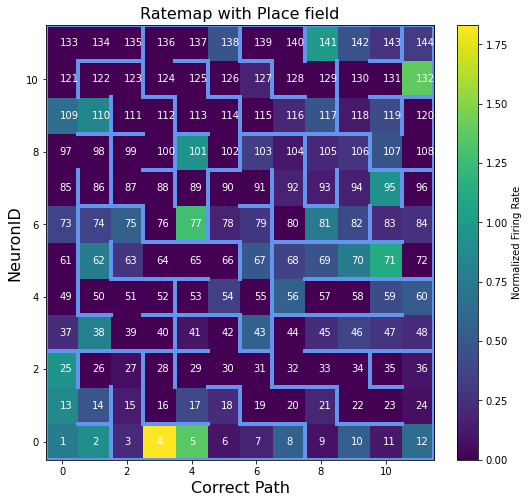

In [10]:
# Calculate the place field
# The definition of palce field is: > 50% maximum firing rate.

# A recursion to approach the entire place field
def Place_field(curr,prev,max,PF,ratemap,maze_type):
    graph = maze1_graph if maze_type==1 else maze2_graph
    surr = graph[curr]
    prev_ind = np.where(surr == prev)[0]
    surr = np.delete(surr,prev_ind)

    # Deep-first searching (DFS) for5 
    for i in range(len(surr)):
        if surr[i] == prev:
            continue
        if ratemap[surr[i]-1] > max*0.5:
            PF.append(surr[i])
            PF = Place_field(surr[i],curr,max,PF,ratemap,maze_type)
    return PF
    

# Find the placeField, return the size of place field PF and the corrlated spatial bin index. 
# [PF, [Max_ind, peak2_ind, ..., peakn_ind]]
def FindPlaceField(ratemap,maze_type = 1):
    graph = maze1_graph if maze_type==1 else maze2_graph
    summit_ind = np.argmax(ratemap)
    max = ratemap[summit_ind]
    # Transform to the correlated spatial bin number SBN
    SBN = summit_ind+1
    
    # We need graph to test the surroundings 
    surr = graph[SBN]
    PF = [SBN] 
    for i in range(len(surr)):
        if ratemap[surr[i]-1] > max*0.5:
            PF.append(surr[i])
            PF = Place_field(surr[i],SBN,max,PF,ratemap,maze_type)
    return [len(PF),PF]

# Example
rate_map_all = Get_split_FRdata(maze_type=1,training_days=1,data_type = 'pc',path_type='no')
print(rate_map_all[0])
PF = FindPlaceField(rate_map_all[0],maze_type = 1)
fig, axes = plt.subplots(1,1,figsize=(8,8))
plot_rate_map(np.reshape(rate_map_all[0], [12,12]),axes,title = "Ratemap with Place field",maze_type=1)
drawMazeOnRatemap(maze_type = 1,axes = axes, color = 'cornflowerblue')
print(PF)

In [11]:
# Establish an all mice place field set.
def GeneratePlaceFieldSet(training_days = 1, maze_type = 1, data_type = 'pc'):
    rate_map_all = Get_split_FRdata(training_days=training_days, data_type=data_type, maze_type=maze_type,path_type='no')
    
    field_size = []
    for i in range(len(rate_map_all)):
        PF = FindPlaceField(rate_map_all[i],maze_type)
        field_size.append(PF[0])
    place_field_means = np.mean(field_size)
    return field_size, place_field_means

def PFChange_with_days(data_type = 'pc'):
    # field size in several days.
    allday_PF_maze1 = [] # record field_size
    means_PF_maze1 = []  # record means
    allday_PF_maze2 = [] # record field_size
    means_PF_maze2 = []  # record means
    distr_maze1 = []     # record distributions
    distr_maze2 = []     # record distributions
    
    fig = plt.figure(figsize=(12,5))
    # plot maze 1
    maze_dic = {
        'day':[],
        'field_size':[],
        'means_PF':[],
        'maze_type':[]
    }
    
    for i in [0,1,2,3,4,5,6,7,8]:
        field_size, place_field_means = GeneratePlaceFieldSet(training_days=i+1,maze_type=1,data_type=data_type)
        maze_dic['field_size'] += field_size
        for j in range(len(field_size)):
            maze_dic['day'].append("D"+str(i+1))
            maze_dic['maze_type'].append(1)
        maze_dic['means_PF'].append(place_field_means)
    
    # plot maze 2
    for i in [9,10,11,12,13,14,15,16]:
        field_size, place_field_means = GeneratePlaceFieldSet(training_days=i-8,maze_type=2,data_type=data_type)
        maze_dic['field_size'] += field_size
        for j in range(len(field_size)):
            maze_dic['day'].append("D"+str(i-8))
            maze_dic['maze_type'].append(2)
        maze_dic['means_PF'].append(place_field_means)  
    
    print(len(maze_dic['field_size']))
    print(len(maze_dic['day']))
    print(len(maze_dic['means_PF']))
    sns.violinplot(x='day',
                   y='field_size',
                   data = maze_dic, 
                   linewidth = 0.5,
                   order = ['D1','D2','D3','D4','D5','D6','D7','D8','D9'],  # 筛选类别
                   width = 0.8,             # 箱之间的间隔比例
                   hue = 'maze_type',       # hue 参数再分类
                   palette = 'hls',         # 设置调色板
                   scale = 'count',         # 测度小提琴图的宽度：area-面积相同，count-按照样本数量决定宽度，width-宽度一样
                   gridsize = 100,          # 设置小提琴图边线的平滑度，越高越平滑
                   inner = 'box',           # 设置内部显示类型 → “box”, “quartile”, “point”, “stick”, None
                   split=True,              # 设置是否拆分小提琴图
                   #bw = 0.2                # 控制拟合程度，一般可以不设置
                  )
    plt.title("size of place field distribution | "+data_type)
    plt.savefig(os.path.join(totalpath,"all_mice_data_maze","PFScatter_violin_"+data_type+".pdf"),dpi=600)
    plt.savefig(os.path.join(totalpath,"all_mice_data_maze","PFScatter_violin_"+data_type+".png"),dpi=600)
    plt.show()
    
    # line graph
    fig = plt.figure(figsize=(12,5))
    plt.plot(np.unique(maze_dic['day']),maze_dic['means_PF'][0:9],label = 'maze 1', color = 'limegreen')
    plt.plot(np.unique(maze_dic['day'])[0:8],maze_dic['means_PF'][9:17],label = 'maze 2', color = 'cornflowerblue')
    plt.xlabel("date")
    plt.ylabel("average field size")
    plt.title("size of place field change in days | "+data_type)
    plt.legend()
    plt.savefig(os.path.join(totalpath,"all_mice_data_maze","PFLinegraph_"+data_type+".pdf"),dpi=600)
    plt.savefig(os.path.join(totalpath,"all_mice_data_maze","PFLinegraph_"+data_type+".png"),dpi=600)
    
    plt.show()
    
# PFChange_with_days(data_type='pc')
# PFChange_with_days(data_type='ac')
# PFChange_with_days(data_type='npc')

In [12]:
# Draw SI and raw firing rate line graph
# This section may need arround 5 to 10 minute
# return an 1 dimension array that consists of the highest value of each neuron.
def peak(rate_map):
    hi = []
    for i in range(len(rate_map)):
        max_ind = np.argmax(rate_map[i])
        max = rate_map[i][max_ind]
        hi.append(max)
    return hi

def peakFR(training_days = 1,maze_type = 1,data_type = 'pc'):
    raw_Rate_map_co= Get_split_FRdata(training_days=training_days, maze_type=maze_type,data_type=data_type, path_type='cp')
    raw_Rate_map_inc= Get_split_FRdata(training_days=training_days, maze_type=maze_type,data_type=data_type, path_type='icp')
    raw_Rate_map_all= Get_split_FRdata(training_days=training_days, maze_type=maze_type,data_type=data_type, path_type='no')

    hi_all = peak(raw_Rate_map_all)
    hi_co = peak(raw_Rate_map_co)
    hi_inc = peak(raw_Rate_map_inc)
    return [hi_all, hi_co, hi_inc]

# Example
# print(highestFR(file,date_expl,maze_type_expl))

def peakFR_Change_with_days(data_type = 'pc'):
    maze_dic = {
        'day':[],
        'maze_type':[],
        'mean_all':[],
        'mean_co':[],
        'mean_inc':[],
        'peak_FR_all':[],
        'peak_FR_co':[],
        'peak_FR_inc':[],
    }
    
    for i in [0,1,2,3,4,5,6,7,8]:
        print("Day ",i+1)
        hi1 = peakFR(training_days = i+1, maze_type = 1, data_type=data_type)
        maze_dic['mean_all'].append(np.mean(hi1[0]))
        maze_dic['mean_co'].append(np.mean(hi1[1]))
        maze_dic['mean_inc'].append(np.mean(hi1[2]))
        
        for j in range(len(hi1[0])):
            maze_dic['day'].append("D"+str(i+1))
            maze_dic['maze_type'].append(1)
        maze_dic['peak_FR_all'] += hi1[0]
        maze_dic['peak_FR_co'] += hi1[1]
        maze_dic['peak_FR_inc'] += hi1[2]
    
    for i in [9,10,11,12,13,14,15,16]:
        print("Day ",i-8)
        hi2 = peakFR(training_days = i-8, maze_type = 2, data_type=data_type)
        maze_dic['mean_all'].append(np.mean(hi2[0]))
        maze_dic['mean_co'].append(np.mean(hi2[1]))
        maze_dic['mean_inc'].append(np.mean(hi2[2]))
        
        for j in range(len(hi2[0])):
            maze_dic['day'].append("D"+str(i-8))
            maze_dic['maze_type'].append(2)
        maze_dic['peak_FR_all'] += hi2[0]
        maze_dic['peak_FR_co'] += hi2[1]
        maze_dic['peak_FR_inc'] += hi2[2]
    
    
    # violinplot of highest_FR_co
    fig = plt.figure(figsize=(16,9))
    sns.violinplot(x='day',
                   y='peak_FR_co',
                   data = maze_dic, 
                   linewidth = 0.5,
                   order = ['D1','D2','D3','D4','D5','D6','D7','D8','D9'],  # 筛选类别
                   width = 0.8,             # 箱之间的间隔比例
                   hue = 'maze_type',       # hue 参数再分类
                   palette = 'hls',         # 设置调色板
                   scale = 'count',         # 测度小提琴图的宽度：area-面积相同，count-按照样本数量决定宽度，width-宽度一样
                   gridsize = 100,          # 设置小提琴图边线的平滑度，越高越平滑
                   inner = 'quartile',           # 设置内部显示类型 → “box”, “quartile”, “point”, “stick”, None
                   split=True,              # 设置是否拆分小提琴图
                   #bw = 0.2                # 控制拟合程度，一般可以不设置
                  )
    plt.title("Distribution of peak firing rate in correct path | "+data_type)
    plt.ylabel("Firing rate (F)")
    plt.xlabel("Training day")
    plt.savefig(os.path.join(totalpath,"all_mice_data_maze","peakFR_co_violinplot_"+data_type+".pdf"),dpi=600)
    plt.savefig(os.path.join(totalpath,"all_mice_data_maze","peakFR_co_violinplot_"+data_type+".png"),dpi=600)
    plt.show()

    fig = plt.figure(figsize=(16,9))
    sns.violinplot(x='day',
                   y='peak_FR_inc',
                   data = maze_dic, 
                   linewidth = 0.5,
                   order = ['D1','D2','D3','D4','D5','D6','D7','D8','D9'],  # 筛选类别
                   width = 0.8,             # 箱之间的间隔比例
                   hue = 'maze_type',       # hue 参数再分类
                   palette = 'hls',         # 设置调色板
                   scale = 'count',         # 测度小提琴图的宽度：area-面积相同，count-按照样本数量决定宽度，width-宽度一样
                   gridsize = 100,          # 设置小提琴图边线的平滑度，越高越平滑
                   inner = 'quartile',           # 设置内部显示类型 → “box”, “quartile”, “point”, “stick”, None
                   split=True,              # 设置是否拆分小提琴图
                   #bw = 0.2                # 控制拟合程度，一般可以不设置
                  )
    plt.title("Distribution of peak firing rate in incorrect path | "+data_type)
    plt.ylabel("Firing rate (F)")
    plt.xlabel("Training day")
    plt.savefig(os.path.join(totalpath,"all_mice_data_maze","peakFR_inc_violinplot_"+data_type+".pdf"),dpi=600)
    plt.savefig(os.path.join(totalpath,"all_mice_data_maze","peakFR_inc_violinplot_"+data_type+".png"),dpi=600)
    plt.show()
    
    fig = plt.figure(figsize=(16,9))
    plt.plot(np.unique(maze_dic['day']),maze_dic['mean_all'][0:9],label = 'all path, maze 1',linewidth = 1.5)
    plt.plot(np.unique(maze_dic['day'])[0:8],maze_dic['mean_all'][9:17],label = 'all path, maze 2',linewidth = 1.5)
    plt.plot(np.unique(maze_dic['day']),maze_dic['mean_co'][0:9],label = 'correct path, maze 1',linewidth = 1.5)
    plt.plot(np.unique(maze_dic['day'])[0:8],maze_dic['mean_co'][9:17],label = 'correct path, maze 2',linewidth = 1.5)
    plt.plot(np.unique(maze_dic['day']),maze_dic['mean_inc'][0:9],'--',label = 'incorrect path, maze 1',linewidth = 1.5)
    plt.plot(np.unique(maze_dic['day'])[0:8],maze_dic['mean_inc'][9:17],'--',label = 'incorrect path, maze 2',linewidth = 1.5)
    plt.title("Average of peak firing rate in each kind of path | "+data_type)
    plt.ylabel("Firing rate (F)")
    plt.xlabel("Training day")
    plt.legend()
    plt.savefig(os.path.join(totalpath,"all_mice_data_maze","peakFR_mean_linegraph_"+data_type+".pdf"),dpi=600)
    plt.savefig(os.path.join(totalpath,"all_mice_data_maze","peakFR_mean_linegraph_"+data_type+".png"),dpi=600)
    plt.show()

# peakFR_Change_with_days(data_type='pc')
# peakFR_Change_with_days(data_type='npc')
# peakFR_Change_with_days(data_type='ac')

In [13]:
# Draw SI and raw firing rate line graph
# This section may need arround 5 to 10 minute
# return an 1 dimension array that consists of the mean value of each neuron.
def meansFR(training_days = 1, maze_type = 1, data_type = 'spikes', select_type = 'pc'):
    # Devide the data into two groups: the correct path group and the incorrect path group
    msdata_co = Get_split_msdata(training_days = training_days, maze_type = maze_type, data_type = data_type, path_type = 'cp')
    msdata_inc = Get_split_msdata(training_days = training_days, maze_type = maze_type, data_type = data_type, path_type = 'icp')
    msdata_all = Get_split_msdata(training_days = training_days, maze_type = maze_type, data_type = data_type, path_type = 'no')
    
    mean_rate_all = []
    mean_rate_all_co = []
    mean_rate_all_inc = []
    
    is_placecell_isi_all = Combination(training_days = training_days, maze_type = maze_type, data_type = 'ispc_isi')
    
    if select_type == 'pc':
        for i in range(len(is_placecell_isi_all)):
            if is_placecell_isi_all[i] == 1:
                mean_rate_all.append(np.nansum(msdata_all[0][i])/msdata_all[2][i])
                mean_rate_all_co.append(np.nansum(msdata_co[0][i])/msdata_co[2][i])
                mean_rate_all_inc.append(np.nansum(msdata_inc[0][i])/msdata_co[2][i])
    
    elif select_type == 'npc':
        for i in range(len(is_placecell_isi_all)):
            if is_placecell_isi_all[i] == 0:
                mean_rate_all.append(np.nansum(msdata_all[0][i])/msdata_all[2][i])
                mean_rate_all_co.append(np.nansum(msdata_co[0][i])/msdata_co[2][i])
                mean_rate_all_inc.append(np.nansum(msdata_inc[0][i])/msdata_co[2][i])
    
    elif select_type == 'ac':
        for i in range(len(is_placecell_isi_all)):
            mean_rate_all.append(np.nansum(msdata_all[0][i])/msdata_all[2][i])
            mean_rate_all_co.append(np.nansum(msdata_co[0][i])/msdata_co[2][i])
            mean_rate_all_inc.append(np.nansum(msdata_inc[0][i])/msdata_co[2][i])
    
    else:
        print("Invalid select_type! there's not a select_type value named "+select_type+"! Please check your spelling!")
        return [[],  [], []]
    
    return [mean_rate_all,  mean_rate_all_co, mean_rate_all_inc]

def meansFR_Change_with_days(select_type = 'pc'):
    maze_dic = {
        'day':[],
        'maze_type':[],
        'mean_all':[],
        'mean_co':[],
        'mean_inc':[],
        'means_FR_all':[],
        'means_FR_co':[],
        'means_FR_inc':[],
    }
    
    for i in [0,1,2,3,4,5,6,7,8]:
        print("Day ",i+1)
        mn1 = meansFR(training_days = i+1, maze_type = 1, data_type = 'spikes', select_type = select_type)
        maze_dic['mean_all'].append(np.nanmean(mn1[0]))
        maze_dic['mean_co'].append(np.nanmean(mn1[1]))
        maze_dic['mean_inc'].append(np.nanmean(mn1[2]))
        
        for j in range(len(mn1[0])):
            maze_dic['day'].append("D"+str(i+1))
            maze_dic['maze_type'].append(1)
        
        maze_dic['means_FR_all'].extend(mn1[0])
        maze_dic['means_FR_co'].extend(mn1[1])
        maze_dic['means_FR_inc'].extend(mn1[2])

    
    for i in [9,10,11,12,13,14,15,16]:
        print("Day ",i-8)
        mn2 = meansFR(training_days = i-8, maze_type = 2, data_type = 'spikes', select_type = select_type)
        maze_dic['mean_all'].append(np.nanmean(mn2[0]))
        maze_dic['mean_co'].append(np.nanmean(mn2[1]))
        maze_dic['mean_inc'].append(np.nanmean(mn2[2]))
        
        for j in range(len(mn2[0])):
            maze_dic['day'].append("D"+str(i-8))
            maze_dic['maze_type'].append(2)
        maze_dic['means_FR_all'].extend(mn2[0])
        maze_dic['means_FR_co'].extend(mn2[1])
        maze_dic['means_FR_inc'].extend(mn2[2])
        
    # violinplot of highest_FR_co
    fig = plt.figure(figsize=(16,9))
    sns.violinplot(x='day',
                   y='means_FR_co',
                   data = maze_dic, 
                   linewidth = 0.5,
                   order = ['D1','D2','D3','D4','D5','D6','D7','D8','D9'],  # 筛选类别
                   width = 0.8,             # 箱之间的间隔比例
                   hue = 'maze_type',       # hue 参数再分类
                   palette = 'hls',         # 设置调色板
                   scale = 'count',         # 测度小提琴图的宽度：area-面积相同，count-按照样本数量决定宽度，width-宽度一样
                   gridsize = 100,          # 设置小提琴图边线的平滑度，越高越平滑
                   inner = 'quartile',           # 设置内部显示类型 → “box”, “quartile”, “point”, “stick”, None
                   split=True,              # 设置是否拆分小提琴图
                   #bw = 0.2                # 控制拟合程度，一般可以不设置
                  )
    plt.title("Distribution of mean firing rate in correct path | "+ select_type)
    plt.ylabel("Firing rate (F)")
    plt.xlabel("Training days")
    plt.savefig(os.path.join(totalpath,"all_mice_data_maze","meansFR_co_violinplot_"+select_type+".pdf"),dpi=600)
    plt.savefig(os.path.join(totalpath,"all_mice_data_maze","meansFR_co_violinplot_"+select_type+".png"),dpi=600)
    plt.show()

    fig = plt.figure(figsize=(16,9))
    sns.violinplot(x='day',
                   y='means_FR_inc',
                   data = maze_dic, 
                   linewidth = 0.5,
                   order = ['D1','D2','D3','D4','D5','D6','D7','D8','D9'],  # 筛选类别
                   width = 0.8,             # 箱之间的间隔比例
                   hue = 'maze_type',       # hue 参数再分类
                   palette = 'hls',         # 设置调色板
                   scale = 'count',         # 测度小提琴图的宽度：area-面积相同，count-按照样本数量决定宽度，width-宽度一样
                   gridsize = 100,          # 设置小提琴图边线的平滑度，越高越平滑
                   inner = 'quartile',           # 设置内部显示类型 → “box”, “quartile”, “point”, “stick”, None
                   split=True,              # 设置是否拆分小提琴图
                   #bw = 0.2                # 控制拟合程度，一般可以不设置
                  )
    plt.title("Distribution of mean firing rate in incorrect path | "+select_type)
    plt.ylabel("Firing rate (F)")
    plt.xlabel("Training days")
    plt.savefig(os.path.join(totalpath,"all_mice_data_maze","meansFR_inc_violinplot_"+select_type+".pdf"),dpi=600)
    plt.savefig(os.path.join(totalpath,"all_mice_data_maze","meansFR_inc_violinplot_"+select_type+".png"),dpi=600)
    plt.show()
    ''''''
    fig = plt.figure(figsize=(16,9))
    plt.plot(np.unique(maze_dic['day']),maze_dic['mean_all'][0:9],label = 'all path, maze 1',linewidth = 1.5)
    plt.plot(np.unique(maze_dic['day'])[0:8],maze_dic['mean_all'][9:17],label = 'all path, maze 2',linewidth = 1.5)
    plt.plot(np.unique(maze_dic['day']),maze_dic['mean_co'][0:9],label = 'correct path, maze 1',linewidth = 1.5)
    plt.plot(np.unique(maze_dic['day'])[0:8],maze_dic['mean_co'][9:17],label = 'correct path, maze 2',linewidth = 1.5)
    plt.plot(np.unique(maze_dic['day']),maze_dic['mean_inc'][0:9],'--',label = 'incorrect path, maze 1',linewidth = 1.5)
    plt.plot(np.unique(maze_dic['day'])[0:8],maze_dic['mean_inc'][9:17],'--',label = 'incorrect path, maze 2',linewidth = 1.5)
    plt.title("Average of mean firing rate in each kind of path | "+select_type)
    plt.ylabel("Firing rate (F)")
    plt.xlabel("Training day")
    plt.legend()
    plt.savefig(os.path.join(totalpath,"all_mice_data_maze","meansFR_mean_linegraph_"+select_type+".pdf"),dpi=600)
    plt.savefig(os.path.join(totalpath,"all_mice_data_maze","meansFR_mean_linegraph_"+select_type+".png"),dpi=600)
    plt.show()
    

# meansFR_Change_with_days(select_type = 'pc')
# meansFR_Change_with_days(select_type = 'npc')
# meansFR_Change_with_days(select_type = 'ac')

[[0.15548684 0.14855017 0.17439681 ... 0.29611883 0.         0.        ]
 [0.42526799 0.4764619  0.26404701 ... 0.26153243 0.         0.        ]
 [0.16700348 0.20551845 0.09823426 ... 0.08648778 0.         0.        ]
 ...
 [0.5345436  0.7701169  0.76436597 ... 0.15938668 0.         0.        ]
 [0.43948285 0.45214058 0.15280885 ... 0.         0.         0.        ]
 [0.0033809  0.01229695 0.00279892 ... 0.         0.         0.        ]]
(449, 1296)
Invalid path type 'no'. Check your spelling! only value 'cp','ap','icp' are acceptable!


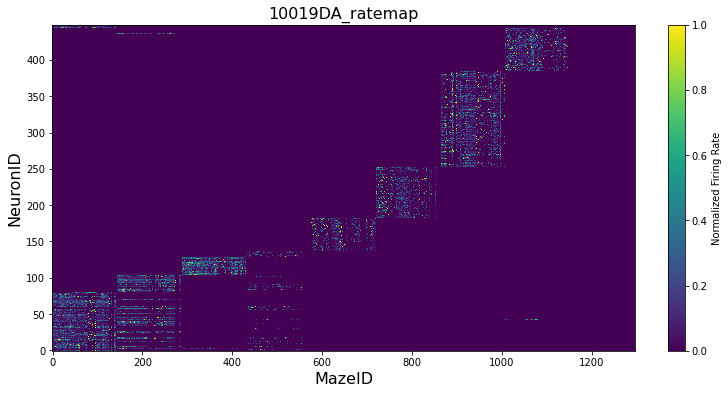

In [14]:
def getCRFiles(NumOfMice, maze_type, file = file):
    ind = np.where((file['number']==NumOfMice)&(file['maze_type']==maze_type))
    CellRegdir = os.path.join("D:\YSY",str(NumOfMice),"Days_aligned","maze"+str(maze_type),"cellRegistered.mat")
    # print(CellRegdir)
    if os.path.exists(CellRegdir):
        f = h5py.File(CellRegdir,'r')
        ms_reg = f['cell_registered_struct']
        index_map = ms_reg['cell_to_index_map']
        # print(index_map)
    else:
        print("Not find the directory, please check your input!")
        return None
    return index_map

def getDaysAligned_Ratemap(onemice_ratemap,index_map,isNorm = 1):
    # the length of onemice_ratemap must be equal to the length of index_map, in axis 0
    # That requires a new method to get the onemice_ratemap, differs from SI_files
    # normalization
    '''
    if isNorm:
        for i in range(len(onemice_ratemap)):
            onemice_ratemap[i] = sklearn.preprocessing.minmax_scale(onemice_ratemap[i], feature_range=(0, 1), axis=1, copy=True)
    '''
    column = 9*144
    row = np.shape(index_map)[1]
    isEightDay = 0
    if len(onemice_ratemap) == 8:
        isEightDay = 1
    DA_ratemap = np.zeros((row,column))
    # print("Shape of DA_ratemap:",np.shape(DA_ratemap))
    
    # begin to copy
    for i in range(9):
        if isEightDay and i==8:
            continue
        day = i
        for n_neu in range(np.shape(index_map)[1]):
            number = index_map[day,n_neu]
            if number == 0:
                for j in range(144*i,144*(i+1)):
                    DA_ratemap[n_neu,j] = 0   # if no the neuron is not found in this day, set is all firing rate = 0
            else:
                for j in range(144*i,144*(i+1)):
                    DA_ratemap[n_neu][j] = onemice_ratemap[day][int(number-1)][j-144*i]
                    # copy the firing rate to DA_ratemap[n_neu,j]
    DA_ratemap = Clear_Ratemap_NaN(DA_ratemap)
    return DA_ratemap                 

def getOnemice_ratemap(NumOfMice,maze_type = 1, file = file):
    onemice_date_index = np.where((file['number'] == NumOfMice)&(file['maze_type']==maze_type))[0]
    onemice_ratemap = []
    for i in onemice_date_index:
        rate_map_all_path = os.path.join("D:\YSY",str(NumOfMice),str(file['date'][i]),"rate_map_all.pkl")
        if os.path.exists(rate_map_all_path):
            #load rate_map_all from pickle file
            with open(rate_map_all_path,'rb') as handle:
                rate_map_all = Norm_ratemap(pickle.load(handle)[2])
                rate_map_all = sort_with_MazeID(rate_map_all = rate_map_all,maze_type = maze_type)
                onemice_ratemap.append(rate_map_all)
                # print("pickle.load(handle[2]): rate_map_all",i,np.shape(rate_map_all))
        else:
            # artificially set the number of neurons as 5000(big enough to make sure that 
            #                                                the length of cell_to_map_index will not larger than this number)
            rate_map_all = np.zeros((5000,144))
            # print("Aritificial setting: rate_map_all",i,np.shape(rate_map_all))
            onemice_ratemap.append(rate_map_all)
    return onemice_ratemap

def sort_with_MazeID(rate_map_all = [], maze_type = 1):
    # clear NaN value
    rate_map_all = Clear_Ratemap_NaN(rate_map_all)

    co_path = CorrectPath_maze_1 if maze_type == 1 else CorrectPath_maze_2
    inco_path = IncorrectPath_maze_1 if maze_type == 1 else IncorrectPath_maze_2
    reor_path = co_path + inco_path
    order_map_all = np.zeros((len(rate_map_all),len(rate_map_all[0])))
    for i in range(len(rate_map_all)):
        for j in range(len(rate_map_all[0])):
            order_map_all[i][j] = rate_map_all[i][int(reor_path[j]-1)]
    return order_map_all

# An example 
index_map_set = getCRFiles(10019,1)
onemice_ratemap = getOnemice_ratemap(10019,1)
print(onemice_ratemap[0])
DA_ratemap = getDaysAligned_Ratemap(onemice_ratemap,index_map_set,1)
print(np.shape(DA_ratemap))
fig, axs = plt.subplots(1,1,figsize=(12,6))
plot_rate_map(DA_ratemap,axs,"10019DA_ratemap",path_type = 'no',maze_type=1)    

In [15]:
# generate DA_ratemap of all cells in all mice.
def getDaysAligned_Ratemap_allmice(maze_type = 1, isGood = 0, file = file):
    # based on all ratemap(including non place cells)
    NumOfMiceset = np.unique(file['number'])
    DA_ratemap_allmice = []
    for i in range(len(NumOfMiceset)):
        targetpath = os.path.join("D:\YSY",str(NumOfMiceset[i]),"Days_aligned","maze"+str(maze_type))
        if os.path.exists(targetpath):
            index_map = np.array(getCRFiles(NumOfMiceset[i],maze_type))
            if isGood:
                index_map = np.array(getGoodCells(index_map))
            onemice_ratemap = getOnemice_ratemap(NumOfMiceset[i],maze_type)
            DA_ratemap = getDaysAligned_Ratemap(onemice_ratemap,index_map,1)
            for j in range(len(DA_ratemap)):
                DA_ratemap_allmice.append(DA_ratemap[j])
    return DA_ratemap_allmice

#  Generate good cells defined as cells whose firing signals have be detected in >= 5 days.
def getGoodCells(index_map):
    goodCells = []
    for k in range(np.shape(index_map)[0]):
        goodCells.append([])
    for i in range(np.shape(index_map)[1]):
        count = np.shape(index_map)[0]
        for j in range(np.shape(index_map)[0]):
            if index_map[j][i] == 0:
                count -= 1
        if count >= 5:
            for j in range(np.shape(index_map)[0]):
                goodCells[j].append(index_map[j][i])
    return goodCells

# sort DA_ratemap in order of mazeID of peak rate
def Bubble_sort(rate_map, index_arr):
    for i in range(len(rate_map)):
        for j in range(len(rate_map)-i-1):
            if   index_arr[j] < index_arr[j+1]:           
                index_arr[j+1], index_arr[j] = index_arr[j], index_arr[j+1]
                c = cp.deepcopy(rate_map[j,:])
                rate_map[j, :] = cp.deepcopy(rate_map[j+1, :])
                rate_map[j+1, :] = cp.deepcopy(c)

def plot_split_DAratemap(maze_type = 1, isGood = 0):
    DA_ratemap_allmice = np.array(getDaysAligned_Ratemap_allmice(maze_type=maze_type,isGood=isGood))
    # index_arr = Generate_Summit_Arr(DA_ratemap_allmice[:,144*day:144*day+144])
    # Bubble_sort(DA_ratemap_allmice, index_arr) 
    
    if isGood == 0:
        raw = 'raw'
    else:
        raw = 'good'
    
    fig, axes = plt.subplots(9,9,figsize = (48,54))
    for k in range(9):
        print("rank day "+str(k+1)+"...")
        index_arr = Generate_Summit_Arr(DA_ratemap_allmice[:,144*k:144*k+144])
        Bubble_sort(DA_ratemap_allmice, index_arr)        
        for i in range(9):
            print("Day "+str(i+1))
            day = i
            plot_rate_map(DA_ratemap_allmice[:,144*day:day*144+144],ax = axes[k][i],
                        title = "maze "+str(maze_type)+", Training day "+str(i+1)+" | all cells",path_type = 'no', maze_type = maze_type)
            
    plt.tight_layout()
    plt.savefig(totalpath,"all_mice_data_maze\DA_ratemap_maze"+str(maze_type)+"_"+raw+"_split.pdf",dpi = 600)
    plt.savefig(totalpath,"all_mice_data_maze\DA_ratemap_maze"+str(maze_type)+"_"+raw+"_split.png",dpi = 600)
    print("Figure has finished.")
    plt.show()
    

# plot_split_DAratemap(maze_type = 1, isGood=0)
# plot_split_DAratemap(maze_type = 2, isGood=0)
# plot_split_DAratemap(maze_type = 1, isGood=1)
# plot_split_DAratemap(maze_type = 2, isGood=1)

In [16]:
# calculate SI (Spatial Information) of correct path and incorrect path
# save the t_total and t_nodes_frac into a file
file = pd.read_excel("D:\YSY\mice_maze_metadata_time_correction.xls", sheet_name = "training_recording_new")

# to return spikes, t_total, t_nodes_frac which are necessary for SI calculation.
def GenerateSIVari(k,j,file = file):
    mylist = [str(file['date'][k]), str(file['number'][k]), int(file['maze_type'][k]), str(file['recording_folder'][k])]
    date = mylist[0]
    NumOfMice = mylist[1]
    maze_type = mylist[2]
    file_path = mylist[3]
    path = os.path.join(totalpath,NumOfMice,date,"ms.mat")

    with h5py.File(path, 'r') as f:
        ms_mat = f['ms']
        # FiltTraces = np.array(ms_mat['FiltTraces'])
        # RawTraces = np.array(ms_mat['RawTraces'])
        DeconvSignal = np.array(ms_mat['DeconvSignals'])
        ms_time = np.array(ms_mat['time'])[0,]

    with open(os.path.join(totalpath,NumOfMice,date,"behav_processed.pkl"), 'rb') as handle:
        behav_time_original, behav_nodes_interpolated, behav_dir = pickle.load(handle)
    
    
    # remove no behav recording period
    behav_mask = (ms_time>=behav_time_original[0]) & (ms_time<behav_time_original[-1])
    #FiltTraces_behav = FiltTraces[:,behav_mask]
    #RawTraces_behav = RawTraces[:,behav_mask]
    DeconvSignal_behav = DeconvSignal[:,behav_mask]
    ms_time_behav = ms_time[behav_mask]
    
    deconv_sd = np.std(DeconvSignal_behav, axis = 1) * 3
    Spikes = np.where(DeconvSignal_behav>np.repeat(deconv_sd[:,np.newaxis], DeconvSignal_behav.shape[1],1), 1, 0)
    # initialze maze object
    start_node = 1
    end_node = 144
    total_bin = 144

    # spike per bin
    spike_nodes = np.zeros_like(Spikes[j,:])
    for i in range(0, len(spike_nodes)):
        if ms_time_behav[i] < behav_time_original[0]:
            spike_nodes[i] = start_node;
        else:
            match_index = np.where(behav_time_original <= ms_time_behav[i])[0][-1]
            spike_nodes[i] = behav_nodes_interpolated[match_index]

    # occupancy map, in ms
    # Duration for each (X,Y) sample (clipped to maxGap)
    maxGap = 100
    stay_time = np.append(np.ediff1d(ms_time_behav),0)
    stay_time[stay_time>maxGap] = maxGap
    _nbins = total_bin
    _coords_range = [0, _nbins +0.0001 ]
    occu_time, xbin_edges, bin_numbers = scipy.stats.binned_statistic(
        spike_nodes,
        stay_time,
        bins=_nbins,
        statistic="sum",
        range=_coords_range)

    assert((bin_numbers == spike_nodes).all())
    minimum_occu_thres = 50 # ms, occupancy time less than the threshold are set to NAN, preventing large spike rate
    occu_time[occu_time<minimum_occu_thres] = np.nan

    ### sum rate map (for first neuron)
    _nbins = total_bin
    _coords_range = [0, _nbins +0.0001 ]
    spikes = Spikes[j,:]

    t_total = np.nansum(occu_time)/1000 # total time of trial
    t_nodes_frac = occu_time/1000/ (t_total+ 1E-6)   # time spent in ith bin/total session time
    return spikes, spike_nodes, t_total, t_nodes_frac

def calc_SI_all(k,file = file):
    print("This is session "+str(k)+": ",str(file['number'][k]),str(file['date'][k]))
    with open(os.path.join(totalpath,str(file['number'][k]),str(file['date'][k]),"rate_map_all.pkl"),'rb') as handle:
        data = pickle.load(handle)
        rate_map_all = data[2]
    print("    Rate_map_all.pkl is openned and read successfully, entering loop...")
    spikes_all = []
    spike_nodes_all = []
    t_total_all = []
    t_nodes_frac_all = []
    for j in range(len(rate_map_all)):
        if int(len(rate_map_all)/10)!=0:
            if j % int(len(rate_map_all)/10) == 0:
                print("      loop:", j*10 / int(len(rate_map_all)/10), " %")
        else:
            print("      loop: 0  %")
        spikes, spike_nodes, t_total, t_nodes_frac = GenerateSIVari(k,j)
        t_total_all.append(t_total)
        t_nodes_frac_all.append(t_nodes_frac)
        spikes_all.append(spikes)
        spike_nodes_all.append(spike_nodes)

    print("    loop is finished...")
    with open(os.path.join("D:\YSY",str(file['number'][k]),str(file['date'][k]),"SI_cal.pkl"), 'wb') as f:
        pickle.dump([spikes_all, spike_nodes_all, t_total_all, t_nodes_frac_all], f)
    print("    This session is calculated successfully! Every file has been saved!")
    print("-------------------------------------------------------------------------")

    
failed_session = [68,130]
fixed_session = [2,12,19,22,76,104,107,118,125]
failed_reason = [
    "session xx: No such file or directory: 'D:\\YSY\\100xx\\20200xxx\\rate_map_all.pkl'  -》no 'time'",
]
'''
for k in range(len(file)):
    if k not in [68,130]:
        calc_SI_all(k)
'''
# LONG TIME RUNNING WARNING!!!
# WARNING!!! This section may need at least 10 HOURS to finish running, for the sake of a huge amount of sessions(151).

'\nfor k in range(len(file)):\n    if k not in [68,130]:\n        calc_SI_all(k)\n'

D1
10027 20200417  Meet a FILE LOSS ERROR!
D:\YSY\10027\20200417\rate_map_pcrc.pkl   LOSS
D:\YSY\10027\20200417\rate_map_all.pkl    LOSS
D:\YSY\10027\20200417\SI_cal.pkl          LOSS
10027 20200417  Meet a FILE LOSS ERROR!
D:\YSY\10027\20200417\rate_map_pcrc.pkl   LOSS
D:\YSY\10027\20200417\rate_map_all.pkl    LOSS
D:\YSY\10027\20200417\SI_cal.pkl          LOSS
10027 20200417  Meet a FILE LOSS ERROR!
D:\YSY\10027\20200417\rate_map_pcrc.pkl   LOSS
D:\YSY\10027\20200417\rate_map_all.pkl    LOSS
D:\YSY\10027\20200417\SI_cal.pkl          LOSS
10027 20200417  Meet a FILE LOSS ERROR!
D:\YSY\10027\20200417\rate_map_pcrc.pkl   LOSS
D:\YSY\10027\20200417\rate_map_all.pkl    LOSS
D:\YSY\10027\20200417\SI_cal.pkl          LOSS
path_type = cp
data_type: spikes
began to calculate time
began to calculate spikes
Finish calculating!
10027 20200417  Meet a FILE LOSS ERROR!
D:\YSY\10027\20200417\rate_map_pcrc.pkl   LOSS
D:\YSY\10027\20200417\rate_map_all.pkl    LOSS
D:\YSY\10027\20200417\SI_cal.pkl    

C:\Users\12454\AppData\Local\Temp\ipykernel_2168\3622664250.py:196: RuntimeWarning: invalid value encountered in true_divide
  logArg = rate_map / mean_rate;
C:\Users\12454\AppData\Local\Temp\ipykernel_2168\3622664250.py:200: RuntimeWarning: invalid value encountered in double_scalars
  SI = IC / mean_rate; # spatial information (bits/spike)


D2
path_type = cp
data_type: spikes
began to calculate time
began to calculate spikes
Finish calculating!
Get_split_FRdata:  (647, 111)
Get_split_FRdata:  (647, 33)
D3
10031 20200420  Meet a FILE LOSS ERROR!
D:\YSY\10031\20200420\rate_map_pcrc.pkl   LOSS
D:\YSY\10031\20200420\rate_map_all.pkl    LOSS
D:\YSY\10031\20200420\SI_cal.pkl          LOSS
10031 20200420  Meet a FILE LOSS ERROR!
D:\YSY\10031\20200420\rate_map_pcrc.pkl   LOSS
D:\YSY\10031\20200420\rate_map_all.pkl    LOSS
D:\YSY\10031\20200420\SI_cal.pkl          LOSS
10031 20200420  Meet a FILE LOSS ERROR!
D:\YSY\10031\20200420\rate_map_pcrc.pkl   LOSS
D:\YSY\10031\20200420\rate_map_all.pkl    LOSS
D:\YSY\10031\20200420\SI_cal.pkl          LOSS
10031 20200420  Meet a FILE LOSS ERROR!
D:\YSY\10031\20200420\rate_map_pcrc.pkl   LOSS
D:\YSY\10031\20200420\rate_map_all.pkl    LOSS
D:\YSY\10031\20200420\SI_cal.pkl          LOSS
path_type = cp
data_type: spikes
began to calculate time
began to calculate spikes
Finish calculating!
10031

C:\Users\12454\AppData\Local\Temp\ipykernel_2168\3622664250.py:195: RuntimeWarning: invalid value encountered in true_divide
  mean_rate = sum(spikes)/t_total # mean firing rate
C:\Users\12454\AppData\Local\Temp\ipykernel_2168\3622664250.py:195: RuntimeWarning: divide by zero encountered in true_divide
  mean_rate = sum(spikes)/t_total # mean firing rate


began to calculate spikes
Finish calculating!
Get_split_FRdata:  (327, 101)
Get_split_FRdata:  (327, 43)
path_type = cp
data_type: spikes
began to calculate time
began to calculate spikes
Finish calculating!
Get_split_FRdata:  (373, 101)
Get_split_FRdata:  (373, 43)


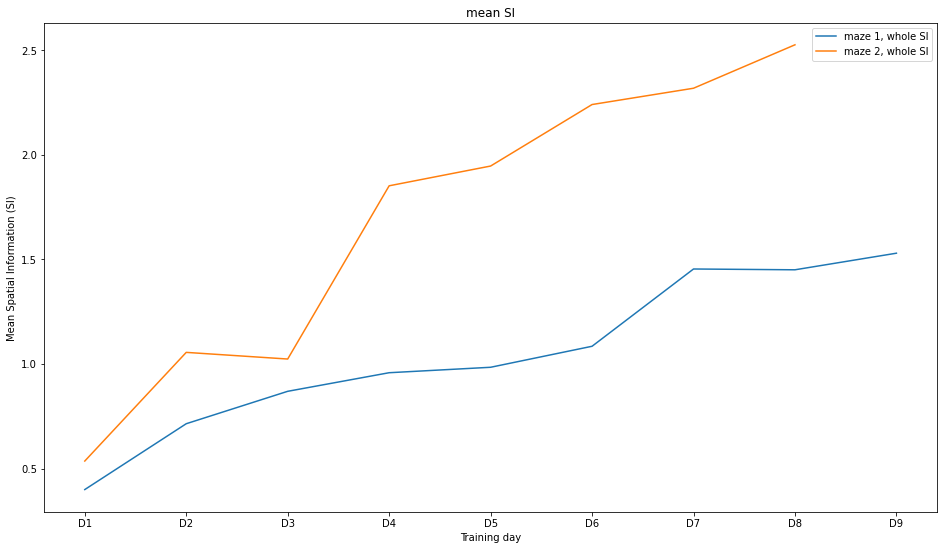

In [45]:
def SI_Change_with_days(data_type = 'pc'):
    maze_dic = {
        'day':[],
        'SI_co':[],
        'SI_inc':[],

        'SI_co_mean':[],
        'SI_inc_mean':[],
        'maze_type':[],
        
        # days for another violin figure
        'Days':[],
        'SI':[],
        'isCorrect':[]
    }
    
    days = ['D1','D2','D3','D4','D5','D6','D7','D8','D9']
    mean1 = []
    mean2 = []
       
    for i in [1,2,3,4,5,6,7,8,9]:
        print("D"+str(i))
        SI, SI_co_all, SI_inc_all = Get_Split_SIdata(training_days=i,maze_type=1,data_type = data_type)
        for j in range(len(SI_co_all)):
            maze_dic['day'].append("D"+str(i))
            maze_dic['maze_type'].append('maze 1')
            maze_dic['Days'] += ["D"+str(i),"D"+str(i)]
            maze_dic['isCorrect'] += ['Correct path']
        for j in range(len(SI_co_all)):
            maze_dic['isCorrect'] += ['Incorrect path']
        maze_dic['SI'] += SI_co_all
        maze_dic['SI'] += SI_inc_all
        maze_dic['SI_co'] += SI_co_all
        maze_dic['SI_inc'] += SI_inc_all
        maze_dic['SI_co_mean'].append(np.nanmean(SI_co_all))
        maze_dic['SI_inc_mean'].append(np.nanmean(SI_inc_all))
        
        mean1.append(np.nanmean(SI))
   
    for i in [1,2,3,4,5,6,7,8]:
        SI, SI_co_all, SI_inc_all = Get_Split_SIdata(training_days=i,maze_type=2,data_type = data_type)
        for j in range(len(SI_co_all)):
            maze_dic['day'].append("D"+str(i))
            maze_dic['maze_type'].append('maze 2')
            maze_dic['Days'] += ["D"+str(i),"D"+str(i)]
            maze_dic['isCorrect'] += ['Correct path']
        for j in range(len(SI_inc_all)):
            maze_dic['isCorrect'] += ['Incorrect path']
        maze_dic['SI'] += SI_co_all
        maze_dic['SI'] += SI_inc_all
        
        maze_dic['SI_co'] += SI_co_all
        maze_dic['SI_inc'] += SI_inc_all
        maze_dic['SI_co_mean'].append(np.nanmean(SI_co_all))
        maze_dic['SI_inc_mean'].append(np.nanmean(SI_inc_all))
        
        mean2.append(np.nanmean(SI))
    '''
    # incorrect path SI
    fig = plt.figure(figsize=(16,9))
    sns.violinplot(x='day',
                   y='SI_co',
                   data = maze_dic, 
                   linewidth = 0.5,
                   order = ['D1','D2','D3','D4','D5','D6','D7','D8','D9'],  # 筛选类别
                   width = 0.8,             # 箱之间的间隔比例
                   hue = 'maze_type',       # hue 参数再分类
                   palette = 'hls',         # 设置调色板
                   scale = 'count',         # 测度小提琴图的宽度：area-面积相同，count-按照样本数量决定宽度，width-宽度一样
                   gridsize = 100,          # 设置小提琴图边线的平滑度，越高越平滑
                   inner = 'quartile',           # 设置内部显示类型 → “box”, “quartile”, “point”, “stick”, None
                   split=True,              # 设置是否拆分小提琴图
                   #bw = 0.2                # 控制拟合程度，一般可以不设置
                  )
    plt.title("Distribution of spatial information in correct path | "+data_type)
    plt.ylabel("SI")
    plt.xlabel("Training day")
    plt.savefig(os.path.join(totalpath,"all_mice_data_maze\SI_co_violinplot_"+data_type+".pdf"),dpi = 600)
    plt.savefig(os.path.join(totalpath,"all_mice_data_maze\SI_co_violinplot_"+data_type+".png"),dpi = 600)
    plt.show()   
    
    
    fig = plt.figure(figsize=(16,9))
    sns.violinplot(x='day',
                   y='SI_inc',
                   data = maze_dic, 
                   linewidth = 0.5,
                   order = ['D1','D2','D3','D4','D5','D6','D7','D8','D9'],  # 筛选类别
                   width = 0.8,             # 箱之间的间隔比例
                   hue = 'maze_type',       # hue 参数再分类
                   palette = 'hls',         # 设置调色板
                   scale = 'count',         # 测度小提琴图的宽度：area-面积相同，count-按照样本数量决定宽度，width-宽度一样
                   gridsize = 100,          # 设置小提琴图边线的平滑度，越高越平滑
                   inner = 'quartile',           # 设置内部显示类型 → “box”, “quartile”, “point”, “stick”, None
                   split=True,              # 设置是否拆分小提琴图
                   #bw = 0.2                # 控制拟合程度，一般可以不设置
                  )
    plt.title("Distribution of spatial information rate in incorrect path | "+data_type)
    plt.ylabel("SI")
    plt.xlabel("Training day")
    plt.savefig(os.path.join(totalpath,"all_mice_data_maze\SI_inc_violinplot_"+data_type+".pdf"),dpi = 600)
    plt.savefig(os.path.join(totalpath,"all_mice_data_maze\SI_inc_violinplot_"+data_type+".png"),dpi = 600)
    plt.show()
    
    # Contrast SI
    fig = plt.figure(figsize=(16,9))
    sns.violinplot(x='Days',
                   y='SI',
                   data = maze_dic, 
                   linewidth = 0.5,
                   order = ['D1','D2','D3','D4','D5','D6','D7','D8','D9'],  # 筛选类别
                   width = 0.8,             # 箱之间的间隔比例
                   hue = 'isCorrect',       # hue 参数再分类
                   palette = 'hls',         # 设置调色板
                   scale = 'count',         # 测度小提琴图的宽度：area-面积相同，count-按照样本数量决定宽度，width-宽度一样
                   gridsize = 100,          # 设置小提琴图边线的平滑度，越高越平滑
                   inner = 'quartile',           # 设置内部显示类型 → “box”, “quartile”, “point”, “stick”, None
                   split=True,              # 设置是否拆分小提琴图
                   #bw = 0.2                # 控制拟合程度，一般可以不设置
                  )
    plt.title("Distribution of spatial information | "+data_type)
    plt.ylabel("SI")
    plt.xlabel("Training day")
    plt.savefig(os.path.join(totalpath,"all_mice_data_maze\SI_IncCo_violinplot_"+data_type+".pdf"),dpi = 600)
    plt.savefig(os.path.join(totalpath,"all_mice_data_maze\SI_IncCo_violinplot_"+data_type+".png"),dpi = 600)
    plt.show()   
    '''
    # It's no sure whether split the spatial information into correct path or incorrect path is appropriate.
    fig = plt.figure(figsize=(16,9))
    plt.plot(days,mean1,linewidth = 1.5, label = 'maze 1, whole SI')
    plt.plot(days[0:8],mean2,linewidth = 1.5, label = 'maze 2, whole SI')
    # plt.plot(np.unique(maze_dic['day']),maze_dic['SI_co_mean'][0:9], label = 'maze 1, correct path', linewidth = 1.5)
    # plt.plot(np.unique(maze_dic['day']),maze_dic['SI_inc_mean'][0:9],'--', label = 'maze 1, incorrect path', linewidth = 1.5)
    # plt.plot(np.unique(maze_dic['day'])[0:8],maze_dic['SI_co_mean'][9:17], label = 'maze 2, correct path', linewidth = 1.5)
    # plt.plot(np.unique(maze_dic['day'])[0:8],maze_dic['SI_inc_mean'][9:17],'--', label = 'maze 2, incorrect path', linewidth = 1.5)
    plt.xlabel("Training day")
    plt.ylabel("Mean Spatial Information (SI)")
    plt.legend()
    plt.title("mean SI")
    plt.savefig(os.path.join(totalpath,"all_mice_data_maze\SI_linegraph_"+data_type+".pdf"),dpi = 600)
    plt.savefig(os.path.join(totalpath,"all_mice_data_maze\SI_linegraph_"+data_type+".png"),dpi = 600)
    plt.show()   
    
SI_Change_with_days(data_type = 'pc')
# SI_Change_with_days(data_type = 'npc')
# SI_Change_with_days(data_type = 'ac')  # bug

(3955, 1296)
(2025, 1296)
dp: [6, 13, 17, 24, 30, 39, 51, 54, 55, 84, 94, 97, 109, 129, 130, 142]
6
True False
13
True False
17
True False
24
True False
30
True False
39
True False
51
True False
54
True False
55
True False
84
True False
94
True False
97
True False
109
True False
129
True False
130
True False
142
True False
[ 10.   2.  12.  23.  14.  70.  69.  60.  59.  44.  47.  77.  78. 105.
 108. 107.]
[ 10.   2.  12.  23.  14.  70.  69.  60.  59.  44.  47.  77.  78. 105.
 108. 107.]
Day 1
dp: [2, 7, 24, 44, 50, 51, 52, 53, 60, 70, 78, 82, 86, 95, 105, 110, 119, 135]
2
True False
7
True False
24
True False
44
True False
50
False True
51
False True
52
True False
53
True False
60
True False
70
True False
78
True False
82
True False
86
True False
95
True False
105
True False
110
True False
119
True False
135
True False
[  2.  39.  53.  45. 122. 118.  32.  31.  88.  85.  66.  84.  11.  92.
  81.  15.  96.  20.]
Day 2
dp: [2, 7, 24, 44, 50, 51, 52, 53, 60, 70, 78, 82, 86, 95, 105, 110, 11

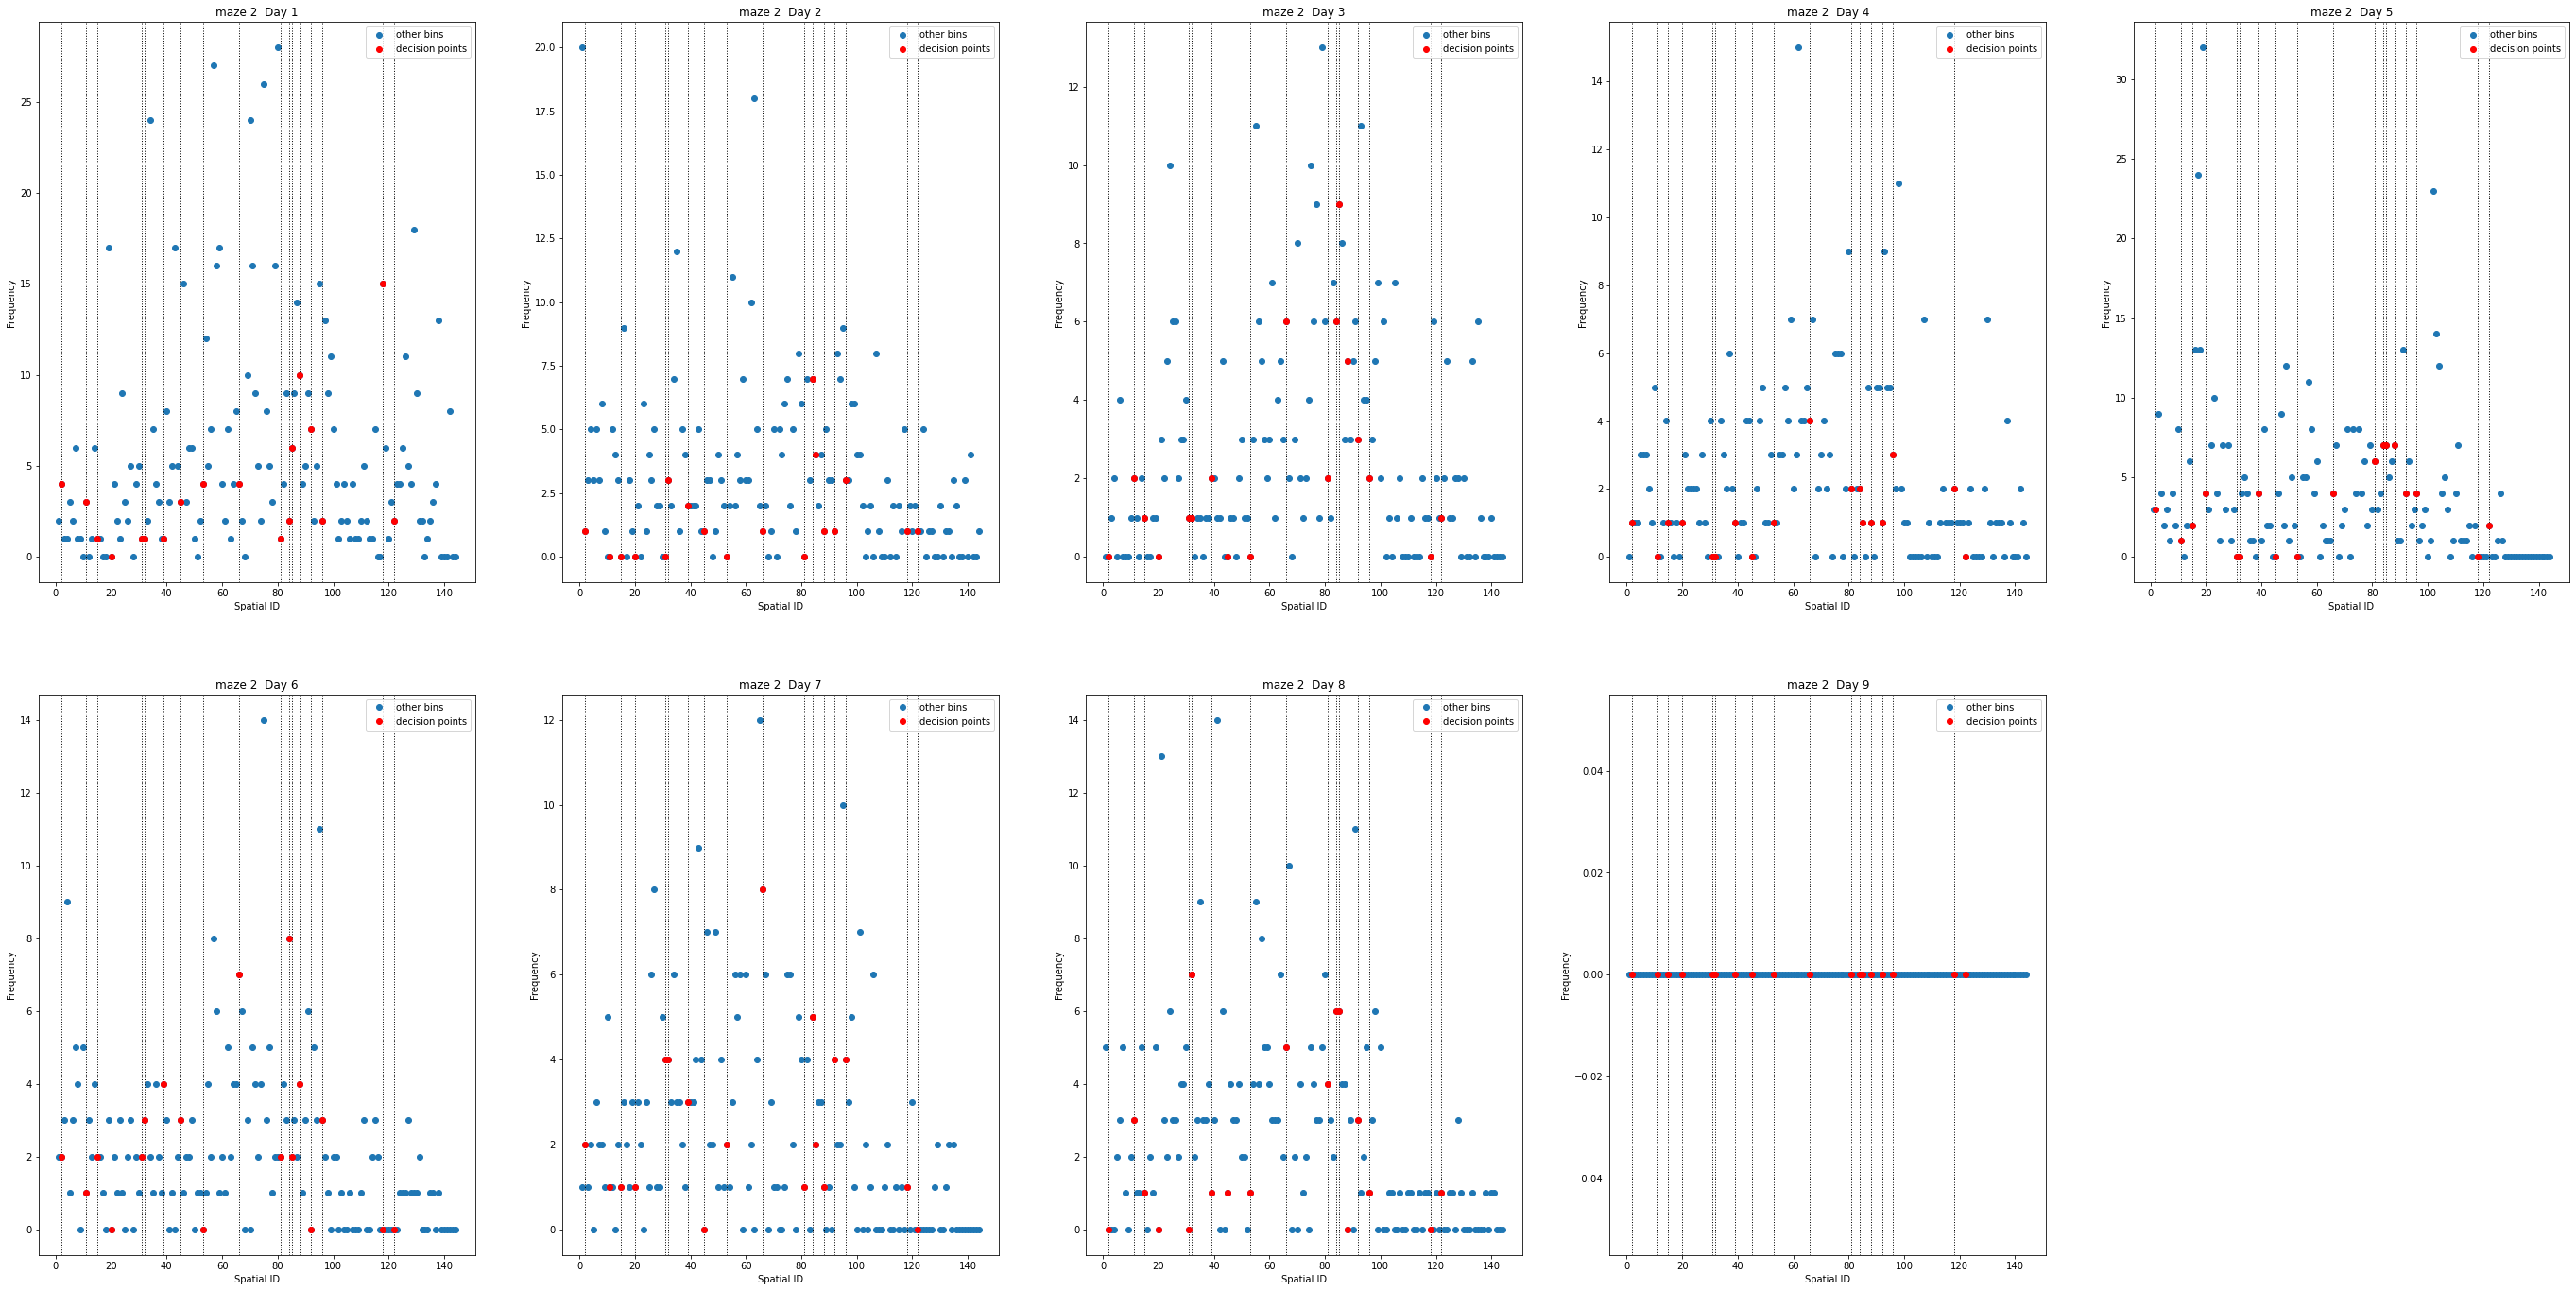

In [47]:
# Distribution of the peak number
file = pd.read_excel("D:\YSY\mice_maze_metadata_time_correction.xls", sheet_name = "training_recording_new")

DA_ratemap_allmice1 = getDaysAligned_Ratemap_allmice(maze_type = 1, isGood = 0)
DA_ratemap_allmice2 = getDaysAligned_Ratemap_allmice(maze_type = 2, isGood = 0)
print(np.shape(DA_ratemap_allmice1))
print(np.shape(DA_ratemap_allmice2))


# find decision point and make guides
def find_Decision_point(maze_type = 1):
    graph = maze1_graph if maze_type == 1 else maze2_graph
    co_path = CorrectPath_maze_1 if maze_type == 1 else CorrectPath_maze_2
    inc_path = IncorrectPath_maze_1 if maze_type == 1 else IncorrectPath_maze_2
    
    dp = []  # list of decision points
    for key in graph.keys():
        # decision points
        if len(graph[key]) >= 3:
            dp.append(key)
    print("dp:",dp)
    new_dp = np.zeros(len(dp))        
    # rank the decision point to new order:
    for i in range(len(dp)):
        print(dp[i])
        print(dp[i] in co_path, dp[i] in inc_path)
        if dp[i] in co_path:
            ind = np.where(np.array(co_path) == dp[i])[0][0]
            new_dp[i] = int(ind+1)
        else:
            ind = np.where(np.array(inc_path) == dp[i])[0][0]
            new_dp[i] = ind + len(co_path)+1
    print(new_dp)
    return new_dp
print(find_Decision_point(1))

def CountDistributionOfPeak(DA_ratemap_allmice, day, DoyouwantPlot,maze_type):
    DA_ratemap_allmice_arr = np.array(DA_ratemap_allmice)
    DA_ratemap = DA_ratemap_allmice_arr[:,144*(day-1):144*day]
    peak_DA_ratemap = np.zeros_like(DA_ratemap)
    
    for i in range(len(DA_ratemap)):
        if np.sum(DA_ratemap[i])==0:
            continue
        peak_DA_ratemap[i][np.argmax(DA_ratemap[i])] = 1
    

    Dist = np.zeros(144)
    for i in range(np.shape(DA_ratemap)[1]):
        for j in range(np.shape(DA_ratemap)[0]):
            if peak_DA_ratemap[j][i]==1:
                Dist[i] += 1
    if DoyouwantPlot==0:
        return Dist
    else:
        dp = find_Decision_point(maze_type)
        plt.plot(range(1,145),Dist,'o',label = "other bins")
        plt.title("maze "+str(maze_type)+'  Day '+str(day))
        plt.xlabel('Spatial ID')
        plt.ylabel('Frequency')
        for i in range(len(dp)):
            plt.axvline(dp[i],color = 'black',linewidth = 1, ls = ':')
        plt.plot(dp,[Dist[int(dp[i]-1)] for i in range(len(dp))], 'o', color = 'red',label = "decision points")
        plt.legend()
        return Dist
'''

maze_type = 1
fig = plt.figure(figsize=(48,24))
for i in range(9):
    print("Day",i+1)
    plt.subplot(2,5,i+1)
    dist = CountDistributionOfPeak(DA_ratemap_allmice1, i+1,1,maze_type)
plt.savefig(r"D:\YSY\all_mice_data_maze\PeakDistribution_scatter_maze1.pdf",dpi=600)
plt.savefig(r"D:\YSY\all_mice_data_maze\PeakDistribution_scatter_maze1.png",dpi=600)
plt.show()    
'''
fig = plt.figure(figsize=(48,24))
maze_type = 2
for i in range(9):
    print("Day",i+1)
    plt.subplot(2,5,i+1)
    dist = CountDistributionOfPeak(DA_ratemap_allmice2, i+1,1,maze_type)
plt.savefig(r"D:\YSY\all_mice_data_maze\PeakDistribution_scatter_maze2.pdf",dpi=600)
plt.savefig(r"D:\YSY\all_mice_data_maze\PeakDistribution_scatter_maze2.png",dpi=600)
plt.show()



dp: [6, 13, 17, 24, 30, 39, 51, 54, 55, 84, 94, 97, 109, 129, 130, 142]
6
True False
13
True False
17
True False
24
True False
30
True False
39
True False
51
True False
54
True False
55
True False
84
True False
94
True False
97
True False
109
True False
129
True False
130
True False
142
True False
[ 10.   2.  12.  23.  14.  70.  69.  60.  59.  44.  47.  77.  78. 105.
 108. 107.]
dp: [ 10.   2.  12.  23.  14.  70.  69.  60.  59.  44.  47.  77.  78. 105.
 108. 107.]
TotolDist: [ 25.  18.  39.  35.  40.  44.  54.  49.  46.  32.  27.  33.  10.  42.
  45.  90.  22.  20.  39.  13.  33.  28.  11.  21.  57.  32.  34.  55.
  14.  39.  51.  45.  48.  22.  24.  55.  41.  28.   4.  28.  36.  21.
  39.  11.  12.  12.   2.  35.  16.  49.  34.  26.  14.  68.  44.  29.
  35.  32.  19.  17.  26.  40.  48.  67.  21.  18.  22.  36.  10.  18.
  15.  21.  17.  31.  34.  36.  14.   8.  21.  51.  23.  79.  26.  31.
 113.  72.  59.  92.  40.  30.  81. 108.  37.  77.  69.  73.  32.  47.
  27. 118.  48. 144.  3

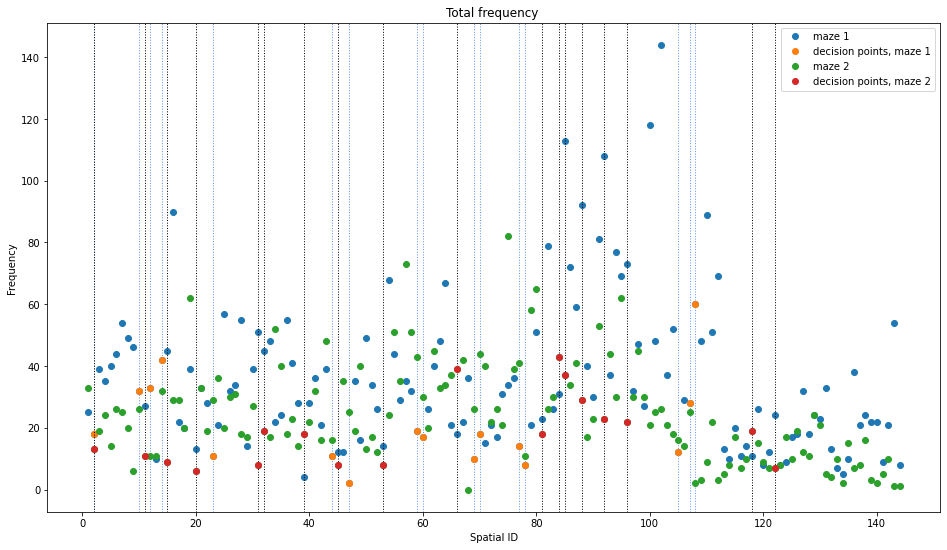

maze ID with peak FR frequency >= 80, maze 1:
[16, 85, 88, 91, 92, 100, 102, 110]
maze ID with peak FR frequency >= 60, maze 2:
[19, 57, 75, 80, 95]
dp: [6, 13, 17, 24, 30, 39, 51, 54, 55, 84, 94, 97, 109, 129, 130, 142]
6
True False
13
True False
17
True False
24
True False
30
True False
39
True False
51
True False
54
True False
55
True False
84
True False
94
True False
97
True False
109
True False
129
True False
130
True False
142
True False
[ 10.   2.  12.  23.  14.  70.  69.  60.  59.  44.  47.  77.  78. 105.
 108. 107.]


array([ 10.,   2.,  12.,  23.,  14.,  70.,  69.,  60.,  59.,  44.,  47.,
        77.,  78., 105., 108., 107.])

In [55]:
def GetDisOfPeak(DA_ratemap_allmice, maze_type):
    Dist = []      # distribution of peak
    TotalDist = np.zeros(144)
    for i in range(9):
        dist = CountDistributionOfPeak(DA_ratemap_allmice, i+1,0,maze_type)
        Dist.append(dist)
        for j in range(144):
            TotalDist[j] += dist[j]
    return Dist, TotalDist

def HistDistributionOfPeak(DA_ratemap_allmice, maze_type):
    Dist, TotalDist = GetDisOfPeak(DA_ratemap_allmice, maze_type)
    dp = find_Decision_point(maze_type)
    print("dp:",dp)
    print("TotolDist:",TotalDist)
    plt.plot(range(1,145),TotalDist,'o',label = "maze "+str(maze_type))
    plt.title("Total frequency ")
    plt.xlabel('Spatial ID')
    c_color = 'cornflowerblue' if maze_type == 1 else 'black'
    for i in range(len(dp)):
        plt.axvline(dp[i], color = c_color, linewidth = 1, ls = ':')
    plt.plot(dp,[TotalDist[int(dp[i]-1)] for i in range(len(dp))], 'o',label = "decision points, maze "+str(maze_type))
    plt.ylabel('Frequency')
    plt.legend()
    
fig = plt.figure(figsize=(16,9))
HistDistributionOfPeak(DA_ratemap_allmice1,1)
HistDistributionOfPeak(DA_ratemap_allmice2,2)
plt.savefig(os.path.join(totalpath,"all_mice_data_maze\PeakDistribution_scatter_total.pdf"), dpi=600)
plt.savefig(os.path.join(totalpath,"all_mice_data_maze\PeakDistribution_scatter_total.png"), dpi=600)
plt.show()

Dist1, TotalDist1 = GetDisOfPeak(DA_ratemap_allmice1, 1)
Dist2, TotalDist2 = GetDisOfPeak(DA_ratemap_allmice2, 2)

higher1 = np.where(TotalDist1 >= 80)[0]
higher2 = np.where(TotalDist2 >= 60)[0]

higher1 = [higher1[i]+1 for i in range(len(higher1))]
higher2 = [higher2[i]+1 for i in range(len(higher2))]
print("maze ID with peak FR frequency >= 80, maze 1:")
print(higher1)
print("maze ID with peak FR frequency >= 60, maze 2:")
print(higher2)
find_Decision_point(1)


Invalid path type 'np'. Check your spelling! only value 'cp','ap','icp' are acceptable!
Invalid path type 'np'. Check your spelling! only value 'cp','ap','icp' are acceptable!


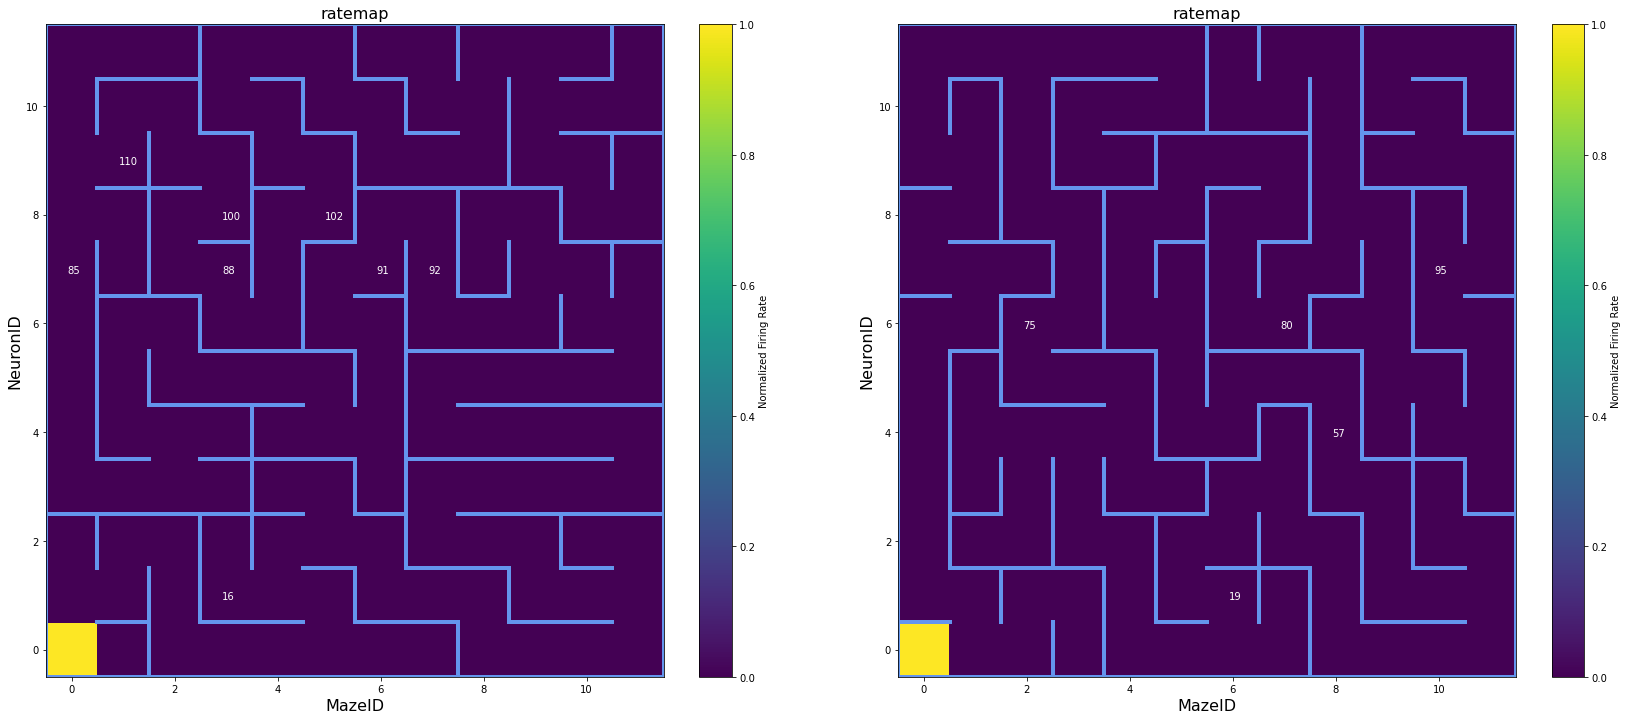

In [65]:
zero_ratemap = np.zeros(144)
zero_ratemap[0] = 1

fig,axs = plt.subplots(1,2,figsize=(28,12))
axes1 = axs[0]
rate_map_2d = np.reshape(zero_ratemap, [12,12])
plot_rate_map(rate_map = rate_map_2d, ax = axes1,title = "ratemap", path_type = 'np', maze_type = 1)
drawMazeOnRatemap(maze_type = 1,axes = axes1,color = 'cornflowerblue')
plot_marker(higher1,axes1)

# marker is the list of some mazeID which you want to mark down in the maze.
def plot_marker(marker,axes):
    for i in marker:
        x = (i-1) % 12
        y = int((i-1) / 12)
        axes.text(x-0.08,y-0.08,i,color = 'white')


axes2 = axs[1]
rate_map_2d = np.reshape(zero_ratemap, [12,12])
plot_rate_map(rate_map = rate_map_2d, ax = axes2, title = "ratemap", path_type='np', maze_type = 2)
drawMazeOnRatemap(maze_type = 2,axes = axes2,color = 'cornflowerblue')
plot_marker(higher2,axes2)

plt.savefig(os.path.join(totalpath,"WorkReport20220406_1.pdf"),dpi=600)
plt.savefig(os.path.join(totalpath,"WorkReport20220406_1.png"),dpi=600)

In [102]:
# calculate path between two points
def DistanceFrStart(maze_type, prev, curr, targ, path, isFind):
    graph = maze1_graph if maze_type==1 else maze2_graph
    surr = graph[curr]
    
    if curr == targ:
        isFind = 1
        
    path.append(curr)
    # print('prev: ',prev,'  curr: ',curr)
    # print('      path:',path)
    for i in range(len(surr)):
        if isFind == 1:
            return path,isFind
        if surr[i] == prev:
            continue
        path, isFind = DistanceFrStart(maze_type, curr, surr[i], targ, path, isFind)
        if isFind == 1:
            return path,isFind
    path.pop()
    return path, isFind

def whichCoreFirst(maze_type = 1,core1 = 1,core2 = 1):
    graph = maze1_graph if maze_type == 1 else maze2_graph
    co_path = CorrectPath_maze_1 if maze_type == 1 else CorrectPath_maze_2
    
    # priority level
    prior1 = 0
    prior2 = 0
    path1 = DistanceFrStart(maze_type, 1, 1, core1,[],0)[0]
    path2 = DistanceFrStart(maze_type, 1, 1, core2,[],0)[0]
    # print('length:',len(path1),path1,len(path2),path2)
    if len(path1) > len(path2):
        return True
    elif len(path1) == len(path2):
        for i in range(len(path1)):
            if path1[len(path1)-1-i] in co_path:
                prior1 += 1
            if path2[len(path2)-1-i] in co_path:
                prior2 += 1
            if prior1 > prior2:
                return True
            elif prior1 < prior2:
                return False
            else:
                continue
        return False
    else:
        return False
        
def BubbleSortWithDistance(WPFmap = {},maze_type = 1):
    if CheckWPFmapCorrect(WPFmap)!=0:
        return
    for i in range(WPFmap['number']):
        for j in range(WPFmap['number']-i-1):
            if whichCoreFirst(maze_type, core1 = WPFmap['core'][j], core2 = WPFmap['core'][j+1]):
                WPFmap['core'][j], WPFmap['core'][j+1] = WPFmap['core'][j+1], WPFmap['core'][j]
                WPFmap['length'][j], WPFmap['length'][j+1] = WPFmap['length'][j+1], WPFmap['length'][j]
                c = cp.deepcopy(WPFmap['WPF'][j])
                WPFmap['WPF'][j] = WPFmap['WPF'][j+1]
                WPFmap['WPF'][j+1] = c
    return WPFmap

10027 20200417  Meet a FILE LOSS ERROR!
D:\YSY\10027\20200417\rate_map_pcrc.pkl   LOSS
D:\YSY\10027\20200417\rate_map_all.pkl    LOSS
D:\YSY\10027\20200417\SI_cal.pkl          LOSS
Get_split_FRdata:  (580, 144)
[0.06164468 0.25406504 0.21299255 0.         0.57291816 0.34662045
 0.6401138  0.15323322 0.3066544  0.52266464 0.29658922 0.69869934
 0.76913216 0.23727607 0.26648901 0.54764513 0.53413097 0.
 0.45334341 0.81833061 1.83079591 0.16747613 1.19694319 0.68135362
 1.86517453 0.94732853 0.68858668 1.64533821 0.         0.26504108
 0.         0.91424392 0.57421763 0.9420927  0.92635479 1.64105624
 0.         0.50813008 0.26171159 0.8242664  0.         0.
 0.         0.         0.2800336  0.         0.81994096 0.
 0.         0.         0.         0.         0.48598736 0.
 0.         0.         1.60513644 0.         0.68166326 1.42775557
 0.73046019 0.         0.81037277 1.85048112 0.60569352 0.
 0.         0.         1.35109052 1.50545728 0.         0.75018755
 0.999001   0.         0.

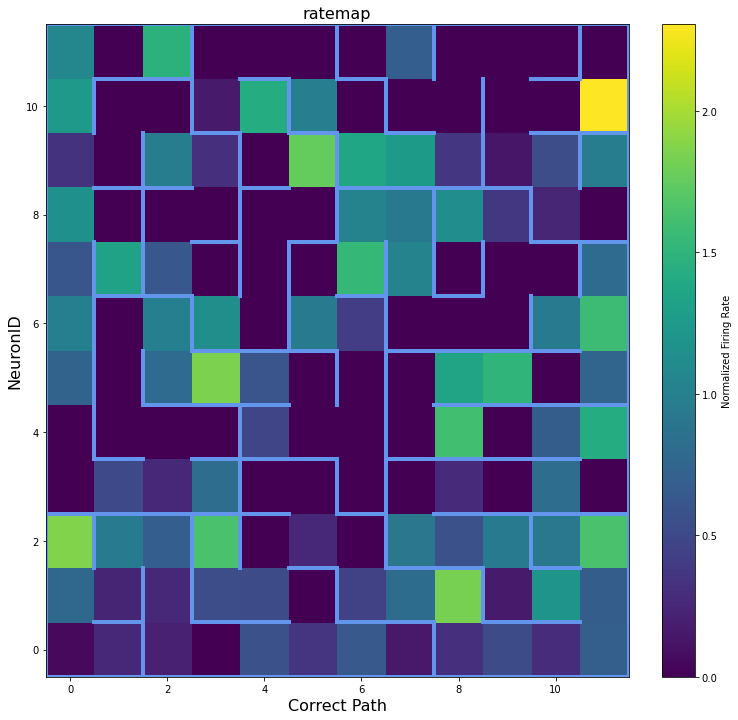

In [103]:
# Second, third,... place field
def Generate_WholePlaceFieldMap(ratemap = [],maze_type = 1):
    graph = maze1_graph if maze_type==1 else maze2_graph
    max = ratemap[np.argmax(ratemap)]
    highFR_ind = np.where(ratemap >= 0.5*max)[0]  # list of spatial bins with firing rate higher than 50% of highest firing rate.
    # print("highFR_ind:",highFR_ind)
    isConcern = np.zeros_like(highFR_ind)
    # print(isConcern)
    Assist = {
        'index':highFR_ind,
        'isConcerned':isConcern
    }
    
    # W(hole)P(lace)F(ield)map contains information about different
    WPFmap = {
        # number of place field
        'maze_type':maze_type,
        'number': 0,
        'WPF':[],                 # list of each subplace field
        'core':[],                # list of core of each subbplace field
        'length':[]               # list of length of each subplace field
    }
    
    # print("assist['index']:",Assist['index']+1)
    # print("assist['isConcerned']:",Assist['isConcerned'])
    
    for i in range(len(Assist['index'])):
        if Assist['isConcerned'][i] == 0:
            core = Assist['index'][i]+1
            lth, PF = FindsubPlaceField(ratemap,maze_type,core,max)
            WPFmap['number'] += 1   # number of place field + 1
            WPFmap['length'].append(len(PF))
            WPFmap['WPF'].append(PF)
            core = ReturnCoreValue(ratemap,PF)
            WPFmap['core'].append(core)
            for i in range(len(PF)):
                ind = np.where(Assist['index'] == PF[i])[0]
                Assist['isConcerned'][ind] = 1
    warn = CheckWPFmapCorrect(WPFmap)
    return WPFmap
                

def ReturnCoreValue(ratemap,PF):
    FR = [ratemap[i-1] for i in PF]
    core = PF[np.argmax(FR)]
    return core

# find a certain subplace field with certain 'core'
def FindsubPlaceField(ratemap, maze_type, core, max):
    graph = maze1_graph if maze_type==1 else maze2_graph
    # We need graph to test the surroundings 
    surr = graph[core]
    PF = [core] 
    for i in range(len(surr)):
        if ratemap[surr[i]-1] > max*0.5:
            PF.append(surr[i])
            PF = Place_field(surr[i],core,max,PF,ratemap,maze_type)
    return [len(PF),PF]

# Check the WPFmap
def CheckWPFmapCorrect(WPFmap):
    warn = 0
    if len(WPFmap['WPF']) != WPFmap['number']:
        print("WARNING!!! The length of WPFmap is not same as the number")
        warn += 1
    if len(WPFmap['core']) != WPFmap['number']:
        print("WARNING!!! The length of core is not same as the number")
        warn += 1
    if len(WPFmap['length']) != WPFmap['number']:
        print("WARNING!!! The length of length is not same as the number")
        warn += 1
    return warn

# sort the subplace fields with field size or firing rate of center, or the distance from start point.
def BubbleSortWithLength(WPFmap):
    if CheckWPFmapCorrect(WPFmap)!=0:
        return
    for i in range(WPFmap['number']):
        for j in range(WPFmap['number']-i-1):
            if WPFmap['length'][j] < WPFmap['length'][j+1]:
                WPFmap['core'][j], WPFmap['core'][j+1] = WPFmap['core'][j+1], WPFmap['core'][j]
                WPFmap['length'][j], WPFmap['length'][j+1] = WPFmap['length'][j+1], WPFmap['length'][j]
                c = cp.deepcopy(WPFmap['WPF'][j])
                WPFmap['WPF'][j] = WPFmap['WPF'][j+1]
                WPFmap['WPF'][j+1] = c
    return WPFmap

def BubbleSortWithcore(WPFmap,ratemap = ratemap):
    if CheckWPFmapCorrect(WPFmap)!=0:
        return
    for i in range(WPFmap['number']):
        for j in range(WPFmap['number']-i-1):
            if ratemap[WPFmap['core'][j]-1] < ratemap[WPFmap['core'][j+1]-1]:
                WPFmap['core'][j], WPFmap['core'][j+1] = WPFmap['core'][j+1], WPFmap['core'][j]
                WPFmap['length'][j], WPFmap['length'][j+1] = WPFmap['length'][j+1], WPFmap['length'][j]
                c = cp.deepcopy(WPFmap['WPF'][j])
                WPFmap['WPF'][j] = WPFmap['WPF'][j+1]
                WPFmap['WPF'][j+1] = c
    return WPFmap

# an example
rate_map_all = Get_split_FRdata(maze_type = 1, data_type = 'pc', training_days = 1,path_type = 'ap')
ratemap = rate_map_all[165]
print(ratemap)
WPFmap = Generate_WholePlaceFieldMap(ratemap = ratemap,maze_type = 1)
print(WPFmap)
WPFmap = BubbleSortWithDistance(WPFmap = WPFmap,maze_type = 1)
print(WPFmap)
fig = plt.figure(figsize=[(12), (12)])
axes = fig.add_subplot(1, 1, 1)
rate_map_2d = np.reshape(ratemap, [12,12])
plot_rate_map(rate_map = rate_map_2d, ax = axes, title = "ratemap", path_type = 'cp', maze_type = 1)
drawMazeOnRatemap(maze_type = 1,axes = axes,color = 'cornflowerblue')

In [104]:
    WPFmap = {
        # number of place field
        'maze_type':2,
        'number': 18,
        'WPF':[[16], 
               [87], 
               [121], 
               [135, 136], 
               [100], [63], 
               [39, 51], 
               [51, 39], 
               [7, 8], 
               [32], 
               [11], 
               [24], 
               [35], 
               [22], 
               [54], 
               [79], 
               [93], 
               [58]],                 
        # list of each subplace field
        'core':[16, 87, 121, 135, 100, 63, 39, 39, 7, 32, 11, 
                24, 35, 22, 54, 79, 93, 58],                
        # list of core of each subbplace field
        'length':[1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]
        # list of length of each subplace field
    }

In [105]:
def countWPFnumber(WPFmap_all):
    number = []
    for i in range(len(WPFmap_all)):
        wmap = WPFmap_all[i]
        number.append(wmap['number'])
    return number

# A(verage)F(ield)Size = sum(WPF['length'])/WPF['number']
def countWPFAverageFieldSize(WPFmap_all):
    AFS = []
    for i in range(len(WPFmap_all)):
        wmap = WPFmap_all[i]
        if wmap['number']==0:
            AFS.append(0)
            continue
        afs = np.sum(wmap['length'])/wmap['number']
        AFS.append(afs)
    return AFS

# T(otal)F(ield)Size = sum(WPF['length'])
def countWPFTotalFieldSize(WPFmap_all):
    TFS = []
    for i in range(len(WPFmap_all)):
        wmap = WPFmap_all[i]
        tfs = np.sum(wmap['length'])
        TFS.append(tfs)
    return TFS

# m(ean)C(ore)F(iring)R(ate) = sum(ratemap[WPF['core'][:]])/WPF['number']
def countWPFmeanCoreFR(WPFmap_all,ratemap):
    mCFR = []
    for i in range(len(WPFmap_all)):
        wmap = WPFmap_all[i]
        if wmap['number'] == 0:
            mCFR.append(0)
            continue
        mCFR.append(np.sum([ratemap[wmap['core'][i]-1] for i in range(wmap['number'])])/wmap['number'])
    return mCFR

def countWPFintervals(WPFmap_all,maze_type):
    Intv = []
    for i in range(len(WPFmap_all)):
        interv = []
        wmap = WPFmap_all[i]
        wmap = BubbleSortWithDistance(wmap,maze_type)
        for j in range(wmap['number']-1):
            interv.append(len(DistanceFrStart(maze_type, wmap['core'][j], wmap['core'][j], wmap['core'][j+1], [], 0)[0]))
        Intv.append(interv)
    return Intv

In [86]:
WPFmap_all = Combination(maze_type = 1, data_type = 'aWPF_pc d',training_days = 1)


10027 20200417  Meet a FILE LOSS ERROR!
D:\YSY\10027\20200417\rate_map_pcrc.pkl   LOSS
D:\YSY\10027\20200417\rate_map_all.pkl    LOSS
D:\YSY\10027\20200417\SI_cal.pkl          LOSS
10027 20200417  Meet a FILE LOSS ERROR!
D:\YSY\10027\20200417\rate_map_pcrc.pkl   LOSS
D:\YSY\10027\20200417\rate_map_all.pkl    LOSS
D:\YSY\10027\20200417\SI_cal.pkl          LOSS
Get_split_FRdata:  (580, 144)
highFR_ind: [  7   8  41  45  88  90 105 109 112]
[0 0 0 0 0 0 0 0 0]
assist['index']: [  8   9  42  46  89  91 106 110 113]
assist['isConcerned']: [0 0 0 0 0 0 0 0 0]
highFR_ind: [75 83 96]
[0 0 0]
assist['index']: [76 84 97]
assist['isConcerned']: [0 0 0]
highFR_ind: [  7   9  15  18  29  30  35  48 135]
[0 0 0 0 0 0 0 0 0]
assist['index']: [  8  10  16  19  30  31  36  49 136]
assist['isConcerned']: [0 0 0 0 0 0 0 0 0]
highFR_ind: [  9  10  13  17  22  23  24  25  30  31  34  39  41  46  55  60  61  62
  76  80  82  88  90  92  94  96 100 113 117 119 120 122 138]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

highFR_ind: [  1   5  71  78  90  91 109 140 141]
[0 0 0 0 0 0 0 0 0]
assist['index']: [  2   6  72  79  91  92 110 141 142]
assist['isConcerned']: [0 0 0 0 0 0 0 0 0]
highFR_ind: [ 29  32  35  57  58  70  77  78  85  88  90  93  96  97  99 101 102 105
 110 136]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
assist['index']: [ 30  33  36  58  59  71  78  79  86  89  91  94  97  98 100 102 103 106
 111 137]
assist['isConcerned']: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
highFR_ind: [ 28  29  30  32  38  39  40  48  64  69  70  71  76  79  83  85  88  89
  91  93  96  98  99 101 102 103 104 106 108 132 133 136 138 141]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
assist['index']: [ 29  30  31  33  39  40  41  49  65  70  71  72  77  80  84  86  89  90
  92  94  97  99 100 102 103 104 105 107 109 133 134 137 139 142]
assist['isConcerned']: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
highFR_ind: [  0   1   4   5   7   8   9  20  21  22  29  30

highFR_ind: [ 89  98 101 135 139 143]
[0 0 0 0 0 0]
assist['index']: [ 90  99 102 136 140 144]
assist['isConcerned']: [0 0 0 0 0 0]
highFR_ind: [ 67  72  99 112 115 125]
[0 0 0 0 0 0]
assist['index']: [ 68  73 100 113 116 126]
assist['isConcerned']: [0 0 0 0 0 0]
highFR_ind: [ 21  37  40  50  63  69  78  79  83  93  98 101 116 133 137]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
assist['index']: [ 22  38  41  51  64  70  79  80  84  94  99 102 117 134 138]
assist['isConcerned']: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
highFR_ind: [ 43  50  63  99 101 106 108 109 139]
[0 0 0 0 0 0 0 0 0]
assist['index']: [ 44  51  64 100 102 107 109 110 140]
assist['isConcerned']: [0 0 0 0 0 0 0 0 0]
highFR_ind: [ 59  94 100 102 108 129 137 143]
[0 0 0 0 0 0 0 0]
assist['index']: [ 60  95 101 103 109 130 138 144]
assist['isConcerned']: [0 0 0 0 0 0 0 0]
highFR_ind: [  2   8   9  15  16  21  24  25  26  29  30  37  47  50  57  62  65  66
  69  70  71  73  74  76  77  78 117 120 128 141]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

highFR_ind: [ 90  95  96  98 108]
[0 0 0 0 0]
assist['index']: [ 91  96  97  99 109]
assist['isConcerned']: [0 0 0 0 0]
highFR_ind: [ 74  79  81  98 109 139]
[0 0 0 0 0 0]
assist['index']: [ 75  80  82  99 110 140]
assist['isConcerned']: [0 0 0 0 0 0]
highFR_ind: [  0   1   2  11  31  43  44  45  46  50  51  52  58  95 105 112 115 116
 117 122 124 125 136]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
assist['index']: [  1   2   3  12  32  44  45  46  47  51  52  53  59  96 106 113 116 117
 118 123 125 126 137]
assist['isConcerned']: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
highFR_ind: [ 26  38  47  49  66  67  74  76  82  84  85  91  94  99 101 103 104 105
 106 107 108 128 129 131 136 138 139 142]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
assist['index']: [ 27  39  48  50  67  68  75  77  83  85  86  92  95 100 102 104 105 106
 107 108 109 129 130 132 137 139 140 143]
assist['isConcerned']: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
highFR_ind: 

highFR_ind: [ 10  14  16  17  92  97 117]
[0 0 0 0 0 0 0]
assist['index']: [ 11  15  17  18  93  98 118]
assist['isConcerned']: [0 0 0 0 0 0 0]
highFR_ind: [ 94 118 142]
[0 0 0]
assist['index']: [ 95 119 143]
assist['isConcerned']: [0 0 0]
highFR_ind: [ 85  95 104]
[0 0 0]
assist['index']: [ 86  96 105]
assist['isConcerned']: [0 0 0]
highFR_ind: [  0   1   4   5   7   9  18  87  90  92  94  96 105 109 112 113]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
assist['index']: [  1   2   5   6   8  10  19  88  91  93  95  97 106 110 113 114]
assist['isConcerned']: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
highFR_ind: [ 84  85  90  94 105 107]
[0 0 0 0 0 0]
assist['index']: [ 85  86  91  95 106 108]
assist['isConcerned']: [0 0 0 0 0 0]
highFR_ind: [ 57  73  74  75  84  85 106 130]
[0 0 0 0 0 0 0 0]
assist['index']: [ 58  74  75  76  85  86 107 131]
assist['isConcerned']: [0 0 0 0 0 0 0 0]
highFR_ind: [ 97 142]
[0 0]
assist['index']: [ 98 143]
assist['isConcerned']: [0 0]
highFR_ind: [  4   7   8   9  10  11  16

highFR_ind: [ 25  29  50 100 115]
[0 0 0 0 0]
assist['index']: [ 26  30  51 101 116]
assist['isConcerned']: [0 0 0 0 0]
highFR_ind: [ 72 101]
[0 0]
assist['index']: [ 73 102]
assist['isConcerned']: [0 0]
highFR_ind: [ 37  72  74  98 106 128]
[0 0 0 0 0 0]
assist['index']: [ 38  73  75  99 107 129]
assist['isConcerned']: [0 0 0 0 0 0]
highFR_ind: [  1  84 108 112 122]
[0 0 0 0 0]
assist['index']: [  2  85 109 113 123]
assist['isConcerned']: [0 0 0 0 0]
highFR_ind: [  4  69  74 108 112]
[0 0 0 0 0]
assist['index']: [  5  70  75 109 113]
assist['isConcerned']: [0 0 0 0 0]
highFR_ind: [  0   1   2   3   4  63  66  67  77  79  80  91  98 107 112 134 135]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
assist['index']: [  1   2   3   4   5  64  67  68  78  80  81  92  99 108 113 135 136]
assist['isConcerned']: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
highFR_ind: [  4   5  41  45  46  69 101 106 110 112 115 118 124]
[0 0 0 0 0 0 0 0 0 0 0 0 0]
assist['index']: [  5   6  42  46  47  70 102 107 111 113 116 119 

highFR_ind: [ 64  98 100 101 107 110 128 136 138]
[0 0 0 0 0 0 0 0 0]
assist['index']: [ 65  99 101 102 108 111 129 137 139]
assist['isConcerned']: [0 0 0 0 0 0 0 0 0]
highFR_ind: [ 53  75  79  89  95 100]
[0 0 0 0 0 0]
assist['index']: [ 54  76  80  90  96 101]
assist['isConcerned']: [0 0 0 0 0 0]
highFR_ind: [ 34  52  53  54  55  62  64  68  69  75  81  83  89  91 117 118 121 123
 126 136 137]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
assist['index']: [ 35  53  54  55  56  63  65  69  70  76  82  84  90  92 118 119 122 124
 127 137 138]
assist['isConcerned']: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
highFR_ind: [ 74  90 108]
[0 0 0]
assist['index']: [ 75  91 109]
assist['isConcerned']: [0 0 0]
highFR_ind: [ 61  62  66  68  75  76  90  94 102 127 136 137]
[0 0 0 0 0 0 0 0 0 0 0 0]
assist['index']: [ 62  63  67  69  76  77  91  95 103 128 137 138]
assist['isConcerned']: [0 0 0 0 0 0 0 0 0 0 0 0]
highFR_ind: [ 67  90 106 107 108 109 110 138]
[0 0 0 0 0 0 0 0]
assist['index']: [ 68 

highFR_ind: [  1   2   4   5  83  96  97  98 101 111 112 130]
[0 0 0 0 0 0 0 0 0 0 0 0]
assist['index']: [  2   3   5   6  84  97  98  99 102 112 113 131]
assist['isConcerned']: [0 0 0 0 0 0 0 0 0 0 0 0]
highFR_ind: [ 99 101]
[0 0]
assist['index']: [100 102]
assist['isConcerned']: [0 0]
highFR_ind: [ 93  98 100 101 142]
[0 0 0 0 0]
assist['index']: [ 94  99 101 102 143]
assist['isConcerned']: [0 0 0 0 0]
highFR_ind: [ 97  99 101 109]
[0 0 0 0]
assist['index']: [ 98 100 102 110]
assist['isConcerned']: [0 0 0 0]
highFR_ind: [ 99 101]
[0 0]
assist['index']: [100 102]
assist['isConcerned']: [0 0]
highFR_ind: [ 87  93  94 100 108 129 140 142]
[0 0 0 0 0 0 0 0]
assist['index']: [ 88  94  95 101 109 130 141 143]
assist['isConcerned']: [0 0 0 0 0 0 0 0]
highFR_ind: [ 93  98 100]
[0 0 0]
assist['index']: [ 94  99 101]
assist['isConcerned']: [0 0 0]
highFR_ind: [ 99 101]
[0 0]
assist['index']: [100 102]
assist['isConcerned']: [0 0]
highFR_ind: [99]
[0]
assist['index']: [100]
assist['isConcerned'

In [112]:
def SubplaceFieldNumber_Change_with_days(selective_type = 'pc'):
    
    # for maze 1
    number_maze_1 = []
    number_maze_2 = []
    fig, axes = plt.subplots(5,2,figsize = (12,30))
    for i in range(9):
        WPFmap_all = Combination(maze_type = 1,data_type = 'aWPF_'+selective_type+' d',training_days = i+1)
        num_distribution = np.zeros(len(WPFmap_all))
        for j in range(len(WPFmap_all)):
            num_distribution[j] = WPFmap_all[j]['number']
        number_maze_1.append(num_distribution)
        ax = axes[int(i/2)][i % 2]
        ax.hist(num_distribution, bins = int(max(num_distribution)), range = [0,int(max(num_distribution))],  histtype='bar', 
                 align='mid', orientation='vertical',color="cornflowerblue")
        ax.set_title("Day "+str(i+1)+" maze1 | Distribution of field number | "+selective_type)
        ax.set_xlabel("field number")
        ax.set_ylabel("Frequency")
        ax.set_xticks([0,10,20,30,40])
    plt.tight_layout()
    plt.savefig(os.path.join(totalpath,"all_mice_data_maze\WPF_numberDistribution_maze1_"+selective_type+".png"),dpi = 600)
    plt.savefig(os.path.join(totalpath,"all_mice_data_maze\WPF_numberDistribution_maze1_"+selective_type+".pdf"),dpi = 600)
    plt.close()
    
    fig, axes = plt.subplots(4,2,figsize = (12,24))
    for i in range(8):
        WPFmap_all = Combination(maze_type = 2,data_type = 'aWPF_'+selective_type+' d',training_days = i+1)
        num_distribution = np.zeros(len(WPFmap_all))
        for j in range(len(WPFmap_all)):
            num_distribution[j] = WPFmap_all[j]['number']
        number_maze_1.append(num_distribution)
        ax = axes[int(i/2)][i % 2]
        ax.hist(num_distribution, bins = int(max(num_distribution)), range = [0,int(max(num_distribution))],  histtype='bar', 
                 align='mid', orientation='vertical',color="cornflowerblue")
        ax.set_title("Day "+str(i+1)+" maze2 | Distribution of field number | "+selective_type)
        ax.set_xlabel("field number")
        ax.set_ylabel("Frequency")
        ax.set_xticks([0,10,20,30,40])
    plt.tight_layout()
    plt.savefig(os.path.join(totalpath,"all_mice_data_maze\WPF_numberDistribution_maze2_"+selective_type+".png"),dpi = 600)
    plt.savefig(os.path.join(totalpath,"all_mice_data_maze\WPF_numberDistribution_maze2_"+selective_type+".pdf"),dpi = 600)
    plt.close()
    
    
# SubplaceFieldNumber_Change_with_days()
        

10027 20200417  Meet a FILE LOSS ERROR!
D:\YSY\10027\20200417\rate_map_pcrc.pkl   LOSS
D:\YSY\10027\20200417\rate_map_all.pkl    LOSS
D:\YSY\10027\20200417\SI_cal.pkl          LOSS
10027 20200417  Meet a FILE LOSS ERROR!
D:\YSY\10027\20200417\rate_map_pcrc.pkl   LOSS
D:\YSY\10027\20200417\rate_map_all.pkl    LOSS
D:\YSY\10027\20200417\SI_cal.pkl          LOSS
Get_split_FRdata:  (580, 144)
Get_split_FRdata:  (429, 144)
10031 20200420  Meet a FILE LOSS ERROR!
D:\YSY\10031\20200420\rate_map_pcrc.pkl   LOSS
D:\YSY\10031\20200420\rate_map_all.pkl    LOSS
D:\YSY\10031\20200420\SI_cal.pkl          LOSS
10031 20200420  Meet a FILE LOSS ERROR!
D:\YSY\10031\20200420\rate_map_pcrc.pkl   LOSS
D:\YSY\10031\20200420\rate_map_all.pkl    LOSS
D:\YSY\10031\20200420\SI_cal.pkl          LOSS
Get_split_FRdata:  (282, 144)
Get_split_FRdata:  (362, 144)
Get_split_FRdata:  (379, 144)
Get_split_FRdata:  (225, 144)
Get_split_FRdata:  (175, 144)
Get_split_FRdata:  (212, 144)
D:\YSY\10027\20200425\rate_map_pcrc.